# Stochastic Simulations Assignment 3: Reverse Engineering Predator-Prey System

#### Job Marcelis, 14000946

#### Ernani Hazbolatow, 14272210

#### Haitham Muhidin, 13970356

Below are the required `Python` packages to run the code.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing, optimize
import scipy.stats as stats
import pandas as pd
from sklearn.neighbors import KernelDensity
import pickle

from joblib import Parallel, delayed

plt.rcParams['figure.dpi'] = 300

To get a better understanding of the Lotka Volterra equations, we solve them using the following parameters: $\alpha = 3$, $\beta = 2$, $\delta = -1$, $\gamma = -2$. Furthermore, we use `solve_ivp` to solve the system of equations deterministically.

In [14]:
def LV_eqs(t, var, params):
    """Calculates next iteration of the Lotka-Volterra equations

    Args:
        t (float): time (not used but required for solve_ivp)
        var (list): predator and prey populations
        params (list): list of model parameters: alpha, beta, gamma, and delta

    Returns:
        list: next iteration of the model
    """
    x, y = var
    a, b, c, d = params

    dxdt = a*x - b*x*y
    dydt = - c*y + d*x*y

    return [dxdt, dydt]

def solve_LV(start_time, stop_time, time_span, initial_conditions, params):
    """Solves the Lotka_Volterra system for some initial conditions, time span, and parameters.

    Args:
        start_time (int): start time
        stop_time (int): stop time
        time_span (array): array of time steps
        initial_conditions (list): list of initial predator and prey populations
        params (list): list of parameters for the model

    Returns:
        arrays: time evolution of the predator and prey populations and the time.
    """
    result = solve_ivp(LV_eqs, [start_time, stop_time], initial_conditions, args=(params,), t_eval=time_span, method='RK45')
    X = result.y[0, :]
    Y = result.y[1, :]
    t = result.t

    return X, Y, t

Below, we solve the LV equations for some initial conditions and parameters from 0 to 20 time units. This way we can visualize the dynamics of the system.

In [15]:
init_cond = [4, 2]
params = [3, 2, 1, 2]
time_arr = np.linspace(0, 20, 1000)
X, Y, t = solve_LV(0, 20, time_arr, init_cond, params)

In addition to showing the time evolution of the deterministic model, we can also plot the phase space for multiple initial conditions. This reveals the periodic behaviour.

In [16]:
pred_pop = [1, 3, 5, 7]
phase_plot_X = np.zeros((len(pred_pop), 1000))
phase_plot_Y = np.zeros((len(pred_pop), 1000))

for i, pop in enumerate(pred_pop):
    X_phase, Y_phase, _ = solve_LV(10, 20, np.linspace(10, 20, 1000), [4, pop], params)
    phase_plot_X[i, :] = X_phase
    phase_plot_Y[i, :] = Y_phase

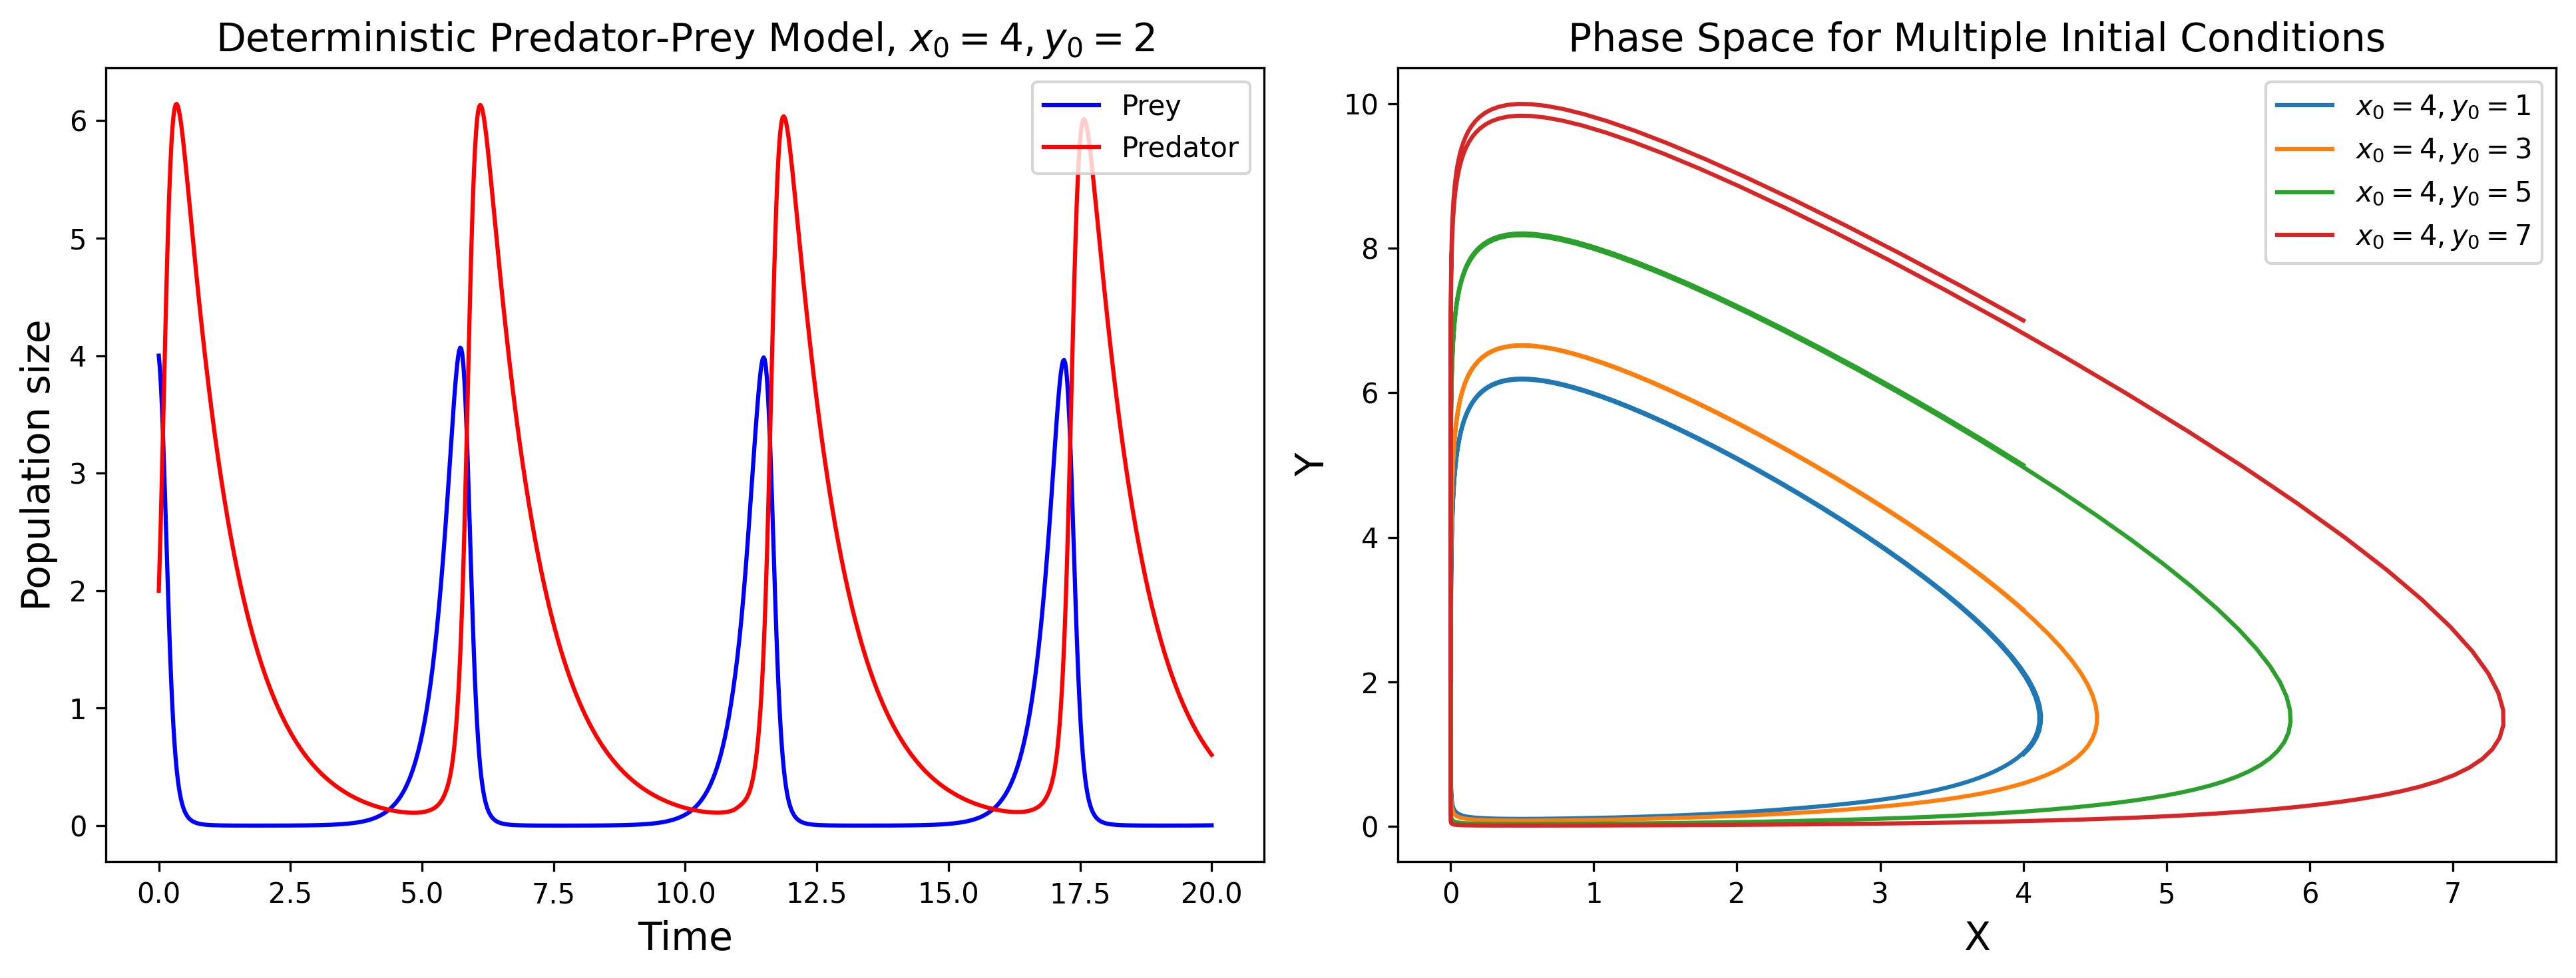

In [17]:
colors = ['#87CEEB', '#ADD8E6', '#00BFFF', '#1E90FF']
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Deterministic Predator-Prey Model, $x_0 = {{{init_cond[0]}}}, y_0 = {{{init_cond[1]}}}$', fontsize=14)
plt.plot(t, X, color='blue', label='Prey')
plt.plot(t, Y, color='red', label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Phase Space for Multiple Initial Conditions', fontsize=14)
for i in range(len(pred_pop)):
    plt.plot(phase_plot_X[i, :], phase_plot_Y[i, :], label=fr'$x_0 = {{{init_cond[0]}}}, y_0 = {{{pred_pop[i]}}}$')
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Now, we plot the data that was given in `predator-prey-data.csv`.

In [18]:
data = pd.read_csv('predator-prey-data.csv')
t_data = data['t']
X_data = data['x']
Y_data = data['y']
X_data_var = np.var(X_data)
Y_data_var = np.var(Y_data)

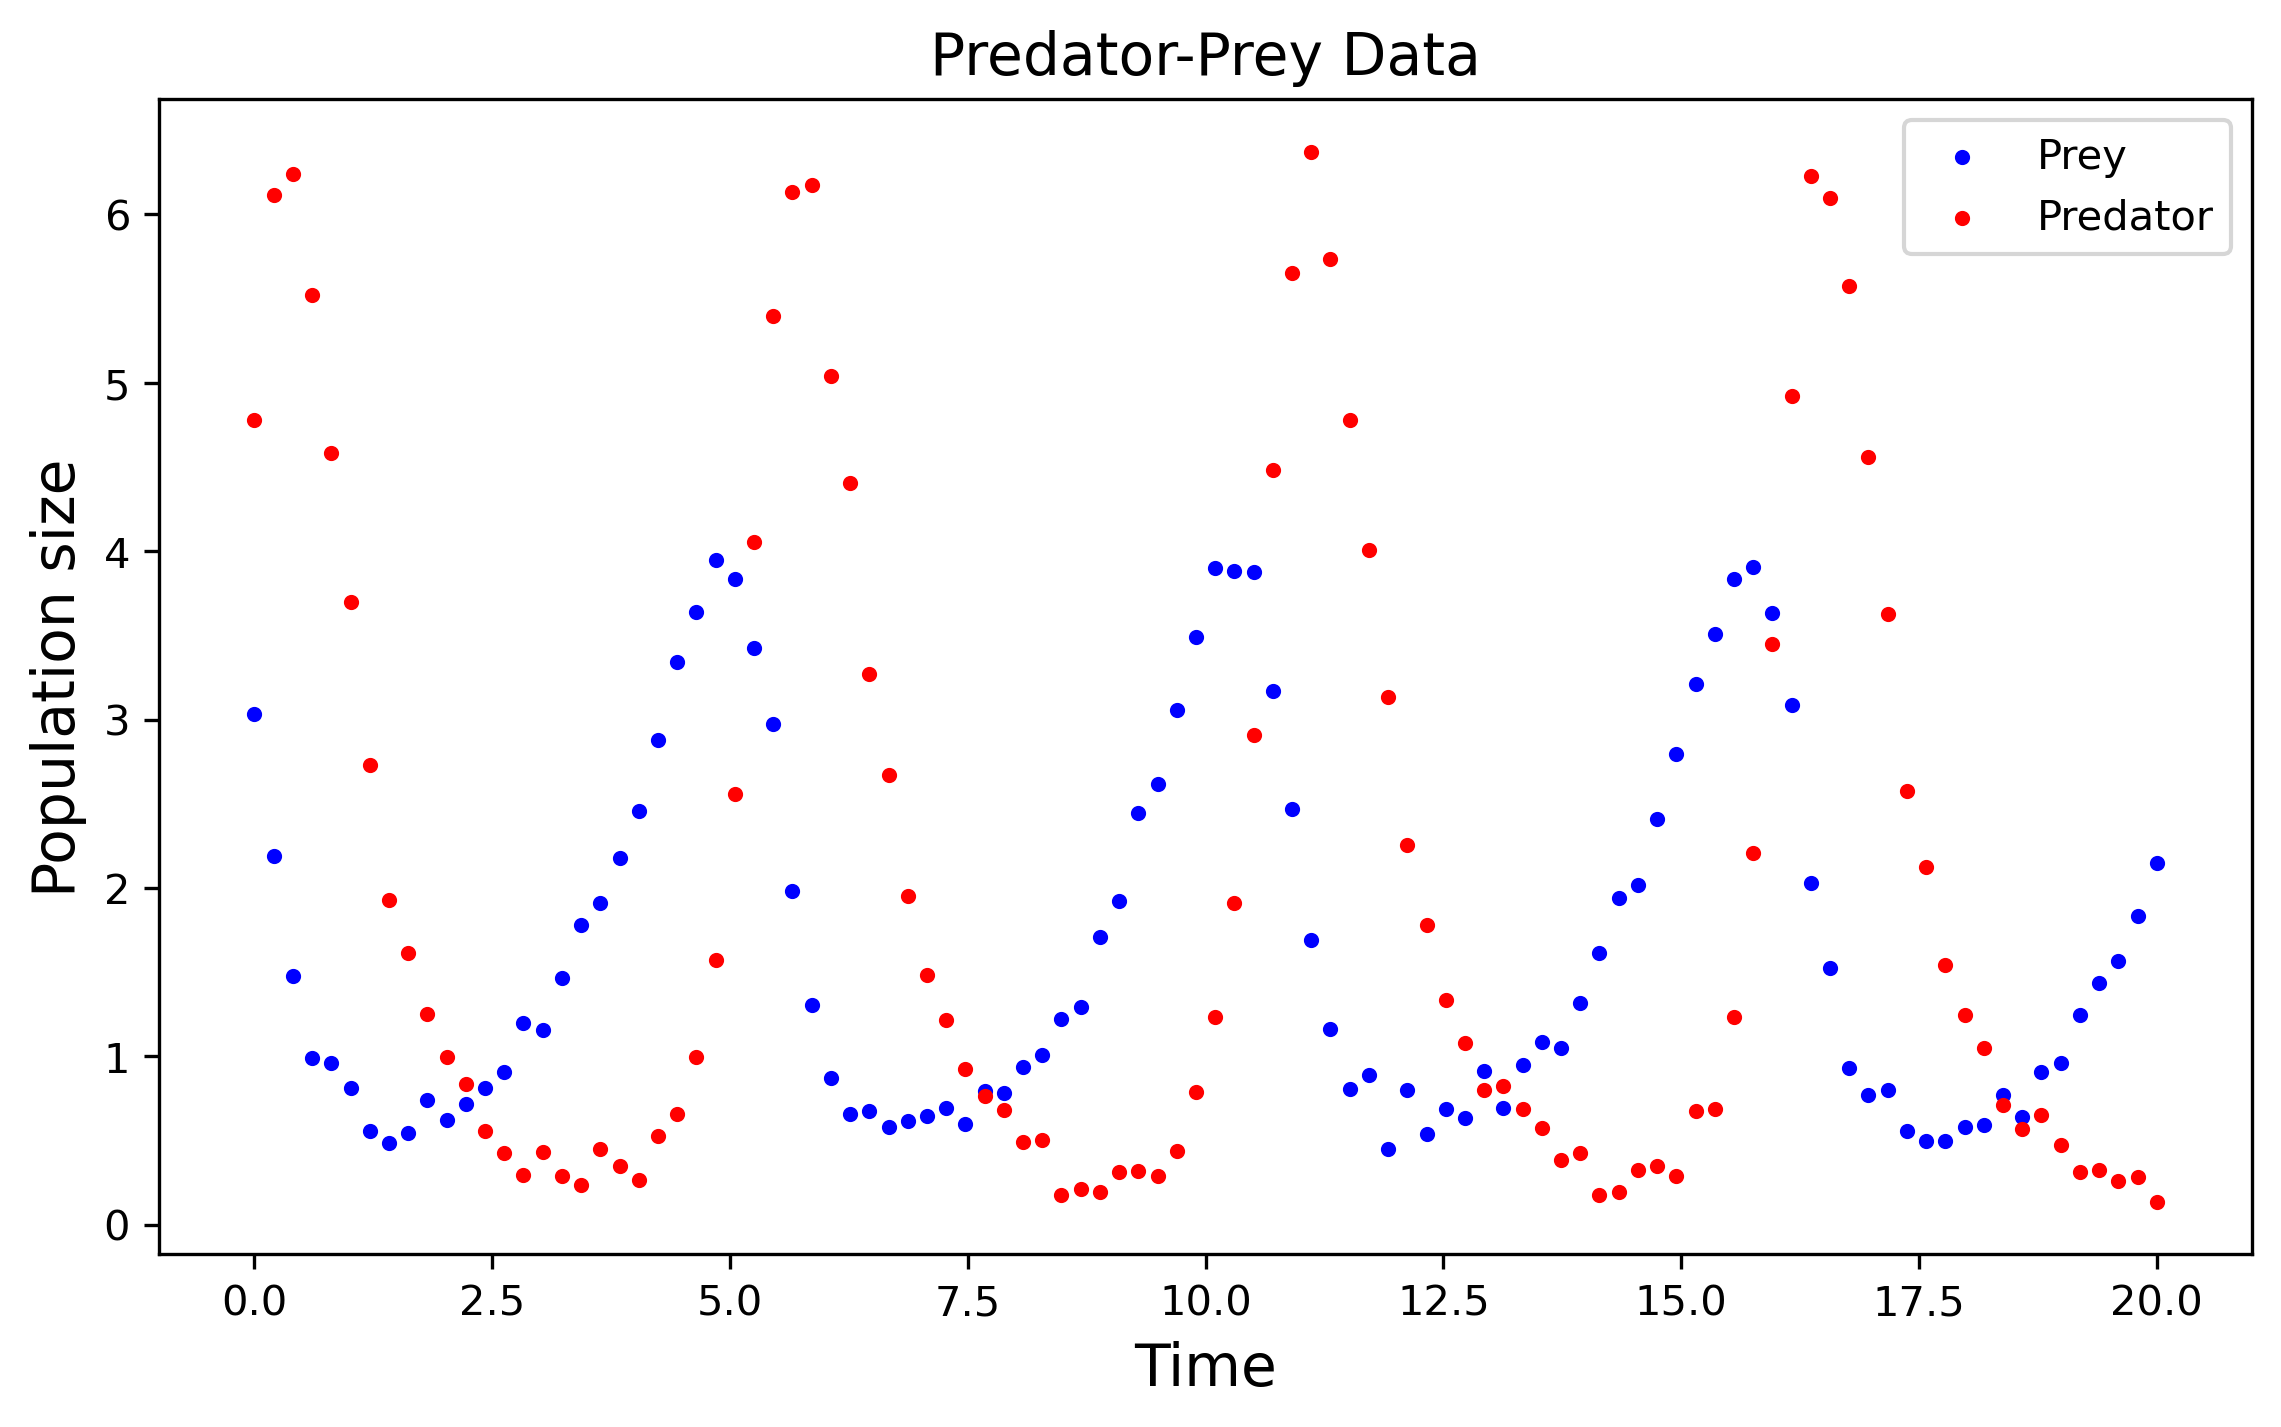

In [7]:
plt.figure(figsize=(9, 5))
plt.title('Predator-Prey Data', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend()
plt.show()

#### Optimization of the model parameters

The goal is to find the best parameters to describe the data, which is done with two different optimizing algorithms, Hill climbing and Simulated Annealing. First, we define two objective functions, the mean squared error (MSE) and the mean absolute error (MAE). Using these functions, we can calculate the difference between the siimulated results and the experimental results.

In [8]:
def MAE(data, model):
    """Calculates the mean absolute error between the data and the model

    Args:
        data (array): original data points
        model (array): predicted points from the model

    Returns:
        float: mean absolute error
    """    
    return np.mean(np.abs(data - model))

def MSE(data, model):
    """Calculates the mean squared error between the data and the model

    Args:
        data (array): original data points
        model (array): predicted points from the model

    Returns:
        float: mean squared error
    """ 
    return np.mean((data - model)**2)

In [11]:
def hill_climbing(init_guess, increment, iterations, obj_func, seed=1):
    """Hill climbing optimization for the parameters of the Lotka-Volterra system

    Args:
        init_guess (list): list of initial guesses for the parameters
        increment (float): size in the increment at each iteration
        iterations (int): total number of iterations 
        obj_func (function): type of objective function (MSE or MAE) 
        seed (int, optional): seed for reproducibility. Defaults to 1.

    Returns:
        list: list of calculated parameters and errors for both populations
    """    

    a, b, c, d = init_guess
    x_errs = []  # will be iterations + 1 long due to also having to compute the initial guess
    y_errs = []  # same as x_errs
    np.random.seed(seed)
    abcd_incr_list = np.random.uniform(-increment, increment, (4, iterations))
    abcd_list = [a,b,c,d]

    model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    x_err = obj_func(X_data, model_X)
    y_err = obj_func(Y_data, model_Y)
    x_errs.append(x_err)
    y_errs.append(y_err)

    for i in range(iterations):

        for j in range(len(abcd_list)):
            abcd_list[j] += abcd_incr_list[j, i]

        model_X, model_Y, model_t = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], abcd_list)
        x_err = obj_func(X_data, model_X)
        y_err = obj_func(Y_data, model_Y)
        x_errs.append(x_err)
        y_errs.append(y_err)

        # if the new total error is larger, than change the parameters back
        if x_errs[-1] + y_errs[-1] > x_errs[-2] + y_errs[-2]:
            
            for j in range(len(abcd_list)):
                abcd_list[j] -= abcd_incr_list[j, i]

    return [abcd_list, x_errs, y_errs]

In [12]:
def calc_mean_conf(results):
    """Calculates the mean of the calculated parameters and the confidence intervals at the p=95% confidence interval

    Args:
        results (array): array with multiple values for the parameters

    Returns:
        arrays: array with the mean and confidence interval of each parameter.
    """    
    means = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(len(results))
    return means, conf

To estimate the goodness of fit, we would usually calculate the reduced $\chi^2$, however, because the data points do not have errors, this is not possible. Instead, we calculate the combined RMSE of the curves to compare the fits of the different optimization methods.

In [9]:
def RMSE(model_prey, model_predator):
    """Calculates root mean squared error of the fit by comparing the predicted model with the data

    Args:
        model_prey (array): X fit using the calculated optimal parameters
        model_predator (array): Y fit using the calculated optimal parameters

    Returns:
        float: root mean squared error
    """    
    return np.sqrt(MSE(X_data, model_prey) + MSE(Y_data, model_predator))

In [38]:
def simulation_wrapper(init_guess, increment, iterations, obj_func, seed_w=1):
    """Simulating wrapper to run hill climbing in parallel."""
    return hill_climbing(init_guess, increment, iterations, obj_func, seed=seed_w)

def simulate_parallel(n_runs, init_guess, increment, iterations, obj_func):
    """Executes hill climbing simulations in parallel.

    Args:
        n_runs (int): number of simulations
        init_guess (list): list of initial guesses for the parameters 
        increment (float): increment size at each iteration
        iterations (int): total number of iterations for hill climbing
        obj_func (function): type of objective function (MSE or MAE) 

    Returns:
        list: list of calculated parameters and errors ofr both populations.
    """    
    results = Parallel(n_jobs=-1)(delayed(simulation_wrapper)(init_guess, increment, iterations, obj_func, seed_w = s) for s in range(n_runs))
    abcds = np.array([results[j][0] for j in range(n_runs)])

    errors_x = np.array([results[k][1] for k in range(n_runs)])
    errors_y = np.array([results[g][2] for g in range(n_runs)])
    return [abcds, errors_x, errors_y]

Running hill climbing simulations with the initial guess $\alpha=1.5$, $\beta = 1$, $\gamma = 2$, and $\delta=1.5$

In [14]:
hill_clim_fit_MAE = simulate_parallel(100, [1.5, 1, 2, 1.5], 0.01, 1000, MAE)
hill_clim_fit_MSE = simulate_parallel(100, [1.5, 1, 2, 1.5], 0.01, 1000, MSE)

In [15]:
# Print results:
means_MAE, conf_MAE = calc_mean_conf(hill_clim_fit_MAE[0])
for i in range(4):
    print(f'(MAE) Param: {means_MAE[i]} +- {conf_MAE[i]}')
means_MSE, conf_MSE = calc_mean_conf(hill_clim_fit_MSE[0])
for i in range(4):
    print(f'(MSE) Param: {means_MSE[i]} +- {conf_MSE[i]}')

(MAE) Param: 1.1208495137247965 +- 0.024342955147927517
(MAE) Param: 0.5876488947506995 +- 0.012997599185531731
(MAE) Param: 1.7597803145050628 +- 0.02356457583547713
(MAE) Param: 1.2818086326300717 +- 0.02077200610690655
(MSE) Param: 1.1946829351727104 +- 0.018080743152958573
(MSE) Param: 0.6942377193687048 +- 0.01537305139155425
(MSE) Param: 1.760672741825305 +- 0.020971918082250976
(MSE) Param: 1.407373708526508 +- 0.022194346023150055


We now make a fit with the calculated optimal parameters:

In [16]:
X_MAE_fit, Y_MAE_fit, t_MAE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE)
X_MSE_fit, Y_MSE_fit, t_MSE_fit = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE)

Using the difference between the predicted model and the data points, we calculate the RMSE and compare between methods

In [19]:
RMSE_MSE_X_hill, RMSE_MSE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE)
RMSE_MAE_X_hill, RMSE_MAE_Y_hill, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE)
RMSE_MSE_hill = RMSE(RMSE_MSE_X_hill, RMSE_MSE_Y_hill)
RMSE_MAE_hill = RMSE(RMSE_MAE_X_hill, RMSE_MAE_Y_hill)
print(f'RMSE for Hill climbing using MSE: {RMSE_MSE_hill}')
print(f'RMSE for Hill climbing using MAE: {RMSE_MAE_hill}')

RMSE for Hill climbing using MSE: 0.7074209297279712
RMSE for Hill climbing using MAE: 0.7817385269646592


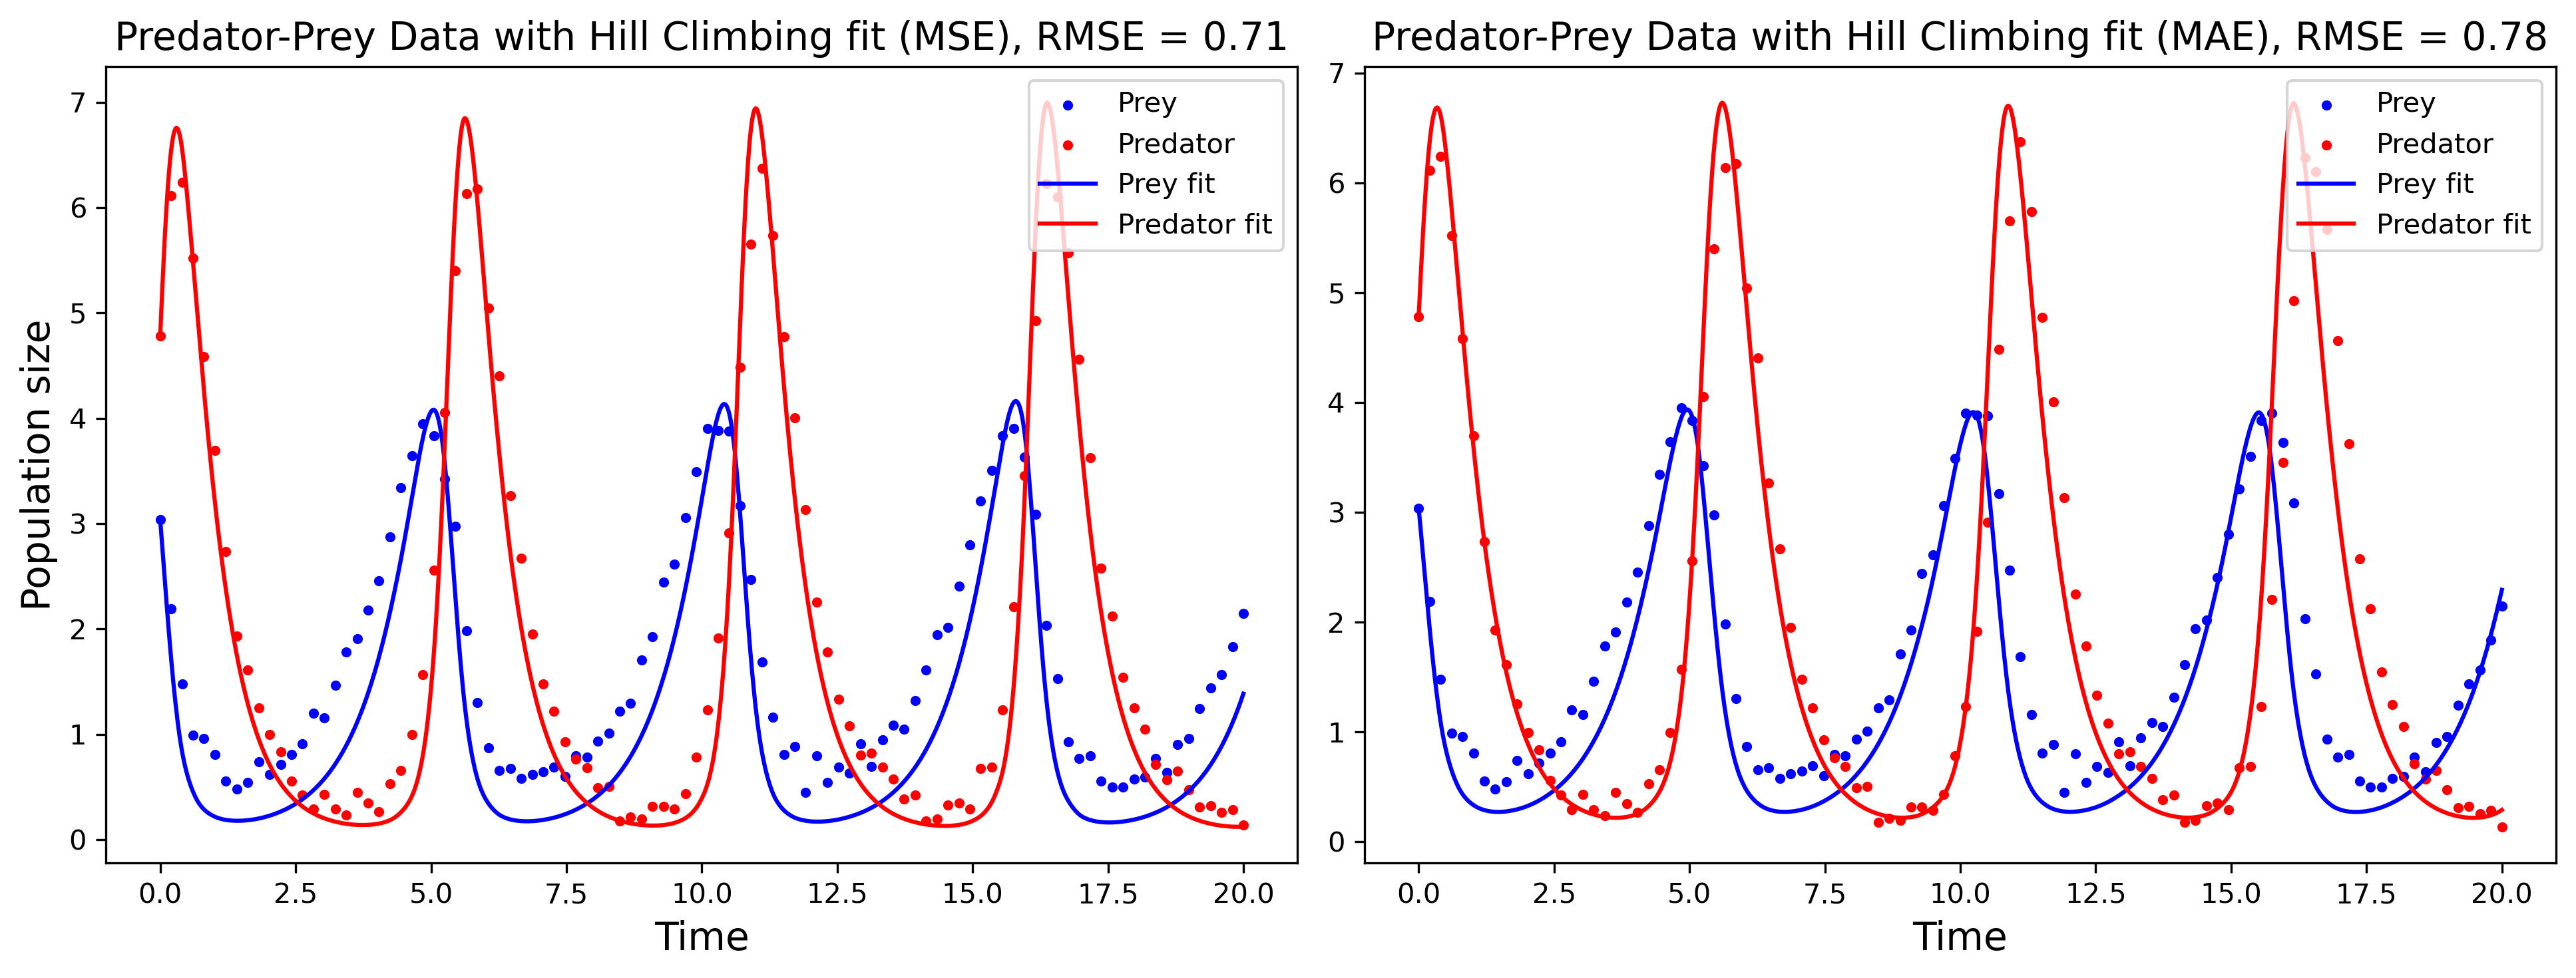

In [20]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MSE), RMSE = {round(RMSE_MSE_hill, 2)}', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MSE_fit, X_MSE_fit, color='blue', label='Prey fit')
plt.plot(t_MSE_fit, Y_MSE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Hill Climbing fit (MAE), RMSE = {round(RMSE_MAE_hill, 2)}', fontsize=14)
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator')
plt.plot(t_MAE_fit, X_MAE_fit, color='blue', label='Prey fit')
plt.plot(t_MAE_fit, Y_MAE_fit, color='red', label='Predator fit')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Simulated Annealing

Below are again two different objective functions (MAE and MSE) to optimize the parameters using simulated annealing. We use `dual_annealing` from `scipy.optmize`. Since this library uses random sampling, we run multiple times and take the mean and confidence interval at the $p = 95\%$ confidence level.

In [36]:
def annealing_MAE(params, X_data, Y_data, t_data):
    """Objective function for simulated annealing using the mean absolute error

    Args:
        params (list): list of model parameters

    Returns:
        float: total error for both fits
    """
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean(np.abs(X_data - model_X))
    error_Y = np.mean(np.abs(Y_data - model_Y))
    return error_X + error_Y

def annealing_MSE(params, X_data, Y_data, t_data):
    """Objective function for simulated annealing using the mean squared error

    Args:
        params (list): list of model parameters

    Returns:
        float: total error for both fits
    """
    a, b, c, d = params
    model_X, model_Y, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean((X_data - model_X) ** 2)
    error_Y = np.mean((Y_data - model_Y) ** 2)
    return error_X + error_Y

bounds = [(0.4, 2.5), (0.4, 2.5), (0.4, 2.5), (0.4, 2.5)]

def run_annealing(obj_func, seed, *args):
    """Simulation wrapper for multithreading

    Args:
        obj_func (function): type of objective function, MAE or MSE
        seed (int): seed for reproducability

    Returns:
        array: array of optimal parameters
    """
    result = dual_annealing(obj_func, bounds, seed=seed, args=args)
    return result.x

Run simulated annealing 100 times for each objective function:

In [37]:
annealing_MSE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MSE, seed*10, X_data, Y_data, t_data) for seed in range(100))
annealing_MAE_results = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MAE, seed*10, X_data, Y_data, t_data) for seed in range(100))

In [39]:
annealing_MSE_results = np.array(annealing_MSE_results)
annealing_MAE_results = np.array(annealing_MAE_results)

means_MSE_SA, conf_MSE_SA = calc_mean_conf(annealing_MSE_results)
means_MAE_SA, conf_MAE_SA = calc_mean_conf(annealing_MAE_results)

In [40]:
# Print results
for i in range(4):
    print(f'(MSE) Param: {means_MSE_SA[i]} +- {conf_MSE_SA[i]}')
    print(f'(MAE) Param: {means_MAE_SA[i]} +- {conf_MAE_SA[i]}')

(MSE) Param: 0.9036471767054496 +- 0.03293780638521311
(MAE) Param: 0.9241643483200996 +- 0.02009161927055961
(MSE) Param: 0.45965116291513686 +- 0.014127423153329363
(MAE) Param: 0.4686058044988966 +- 0.009672453392706224
(MSE) Param: 1.9615564226755842 +- 0.046308146381228175
(MAE) Param: 1.8908794225000427 +- 0.036308936248347856
(MSE) Param: 1.1422806169262762 +- 0.023945415651470094
(MAE) Param: 1.0999000099053555 +- 0.02099777896876469


In [41]:
anneal_fit_MSE_X, anneal_fit_MSE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MSE_SA)
anneal_fit_MAE_X, anneal_fit_MAE_Y, anneal_fit_t = solve_LV(0, 20, time_arr, [X_data[0], Y_data[0]], means_MAE_SA)

Calculate RMSE of these fits and compare to each other and the hill climbing results:

In [42]:
RMSE_MSE_X_SA, RMSE_MSE_Y_SA, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MSE_SA)
RMSE_MAE_X_SA, RMSE_MAE_Y_SA, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], means_MAE_SA)
RMSE_MSE_SA = RMSE(RMSE_MSE_X_SA, RMSE_MSE_Y_SA)
RMSE_MAE_SA = RMSE(RMSE_MAE_X_SA, RMSE_MAE_Y_SA)
print(f'RMSE using MSE: {RMSE_MSE_SA}')
print(f'RMSE using MAE: {RMSE_MAE_SA}')

RMSE using MSE: 0.49858518682711545
RMSE using MAE: 0.16621210255964808


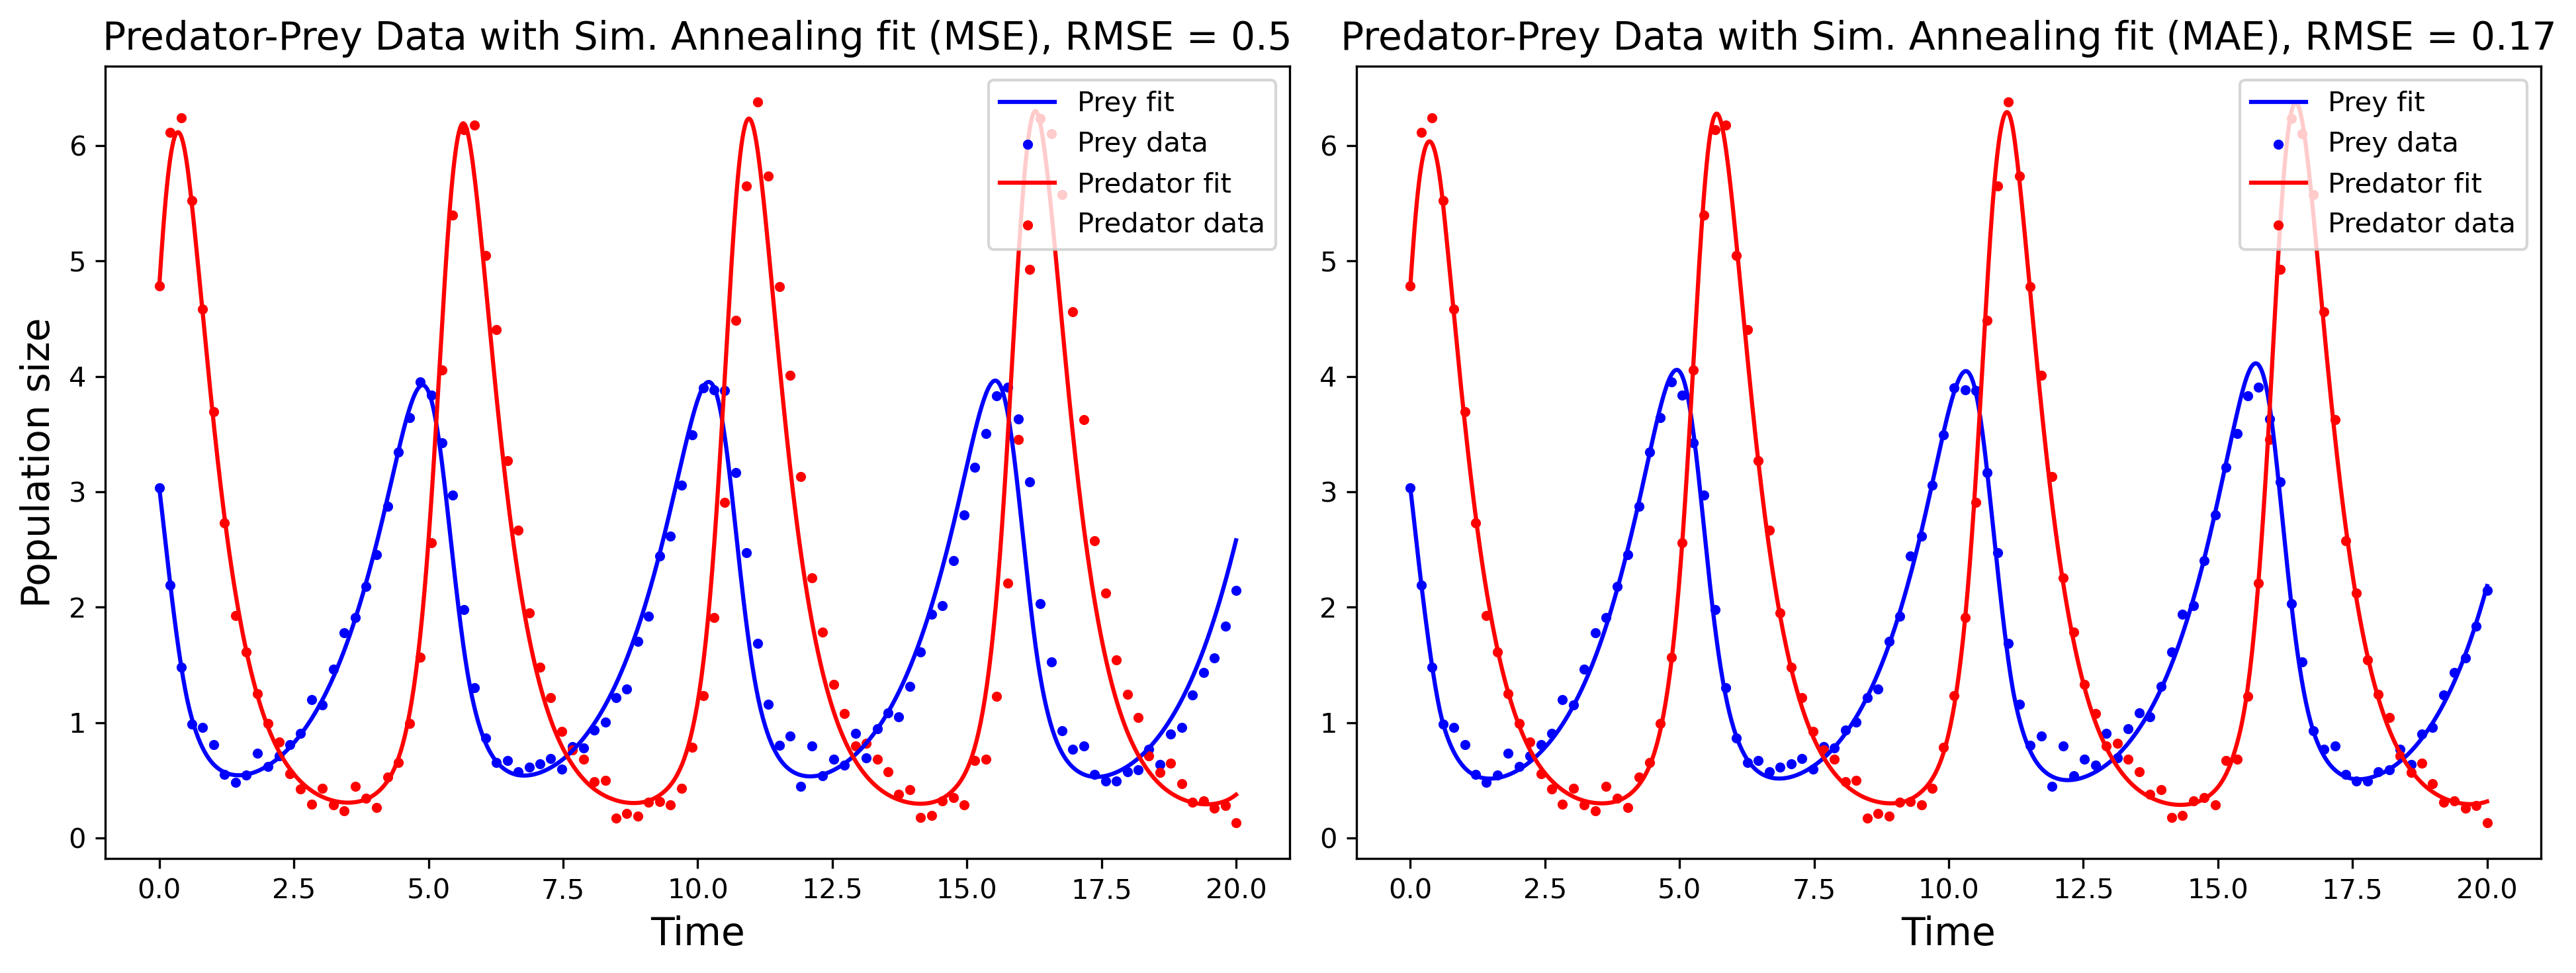

In [43]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title(fr'Predator-Prey Data with Sim. Annealing fit (MSE), RMSE = {round(RMSE_MSE_SA, 2)}', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_MSE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_MSE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population size', fontsize=14)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title(fr'Predator-Prey Data with Sim. Annealing fit (MAE), RMSE = {round(RMSE_MAE_SA, 2)}', fontsize=14)
plt.plot(anneal_fit_t, anneal_fit_MAE_X, color='blue', label='Prey fit')
plt.scatter(t_data, X_data, color='blue', s=7, label='Prey data')
plt.plot(anneal_fit_t, anneal_fit_MAE_Y, color='red', label='Predator fit')
plt.scatter(t_data, Y_data, color='red', s=7, label='Predator data')
plt.xlabel('Time', fontsize=14)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

We determine how many data points we can delete while still getting a good fit. First, we fix the $x$ data and randomly delete points from the $y$ data, we then calculate the parameters with less data and if the resulting parameters fall within the confidence interval of the original parameters, we conclude that we can still reverse engineer the dynamics. For this part we use simulated annealing with the MAE as objective function, since that gave the lowest RMSE. 

In [44]:
annealing_MAE_baseline = Parallel(n_jobs=-1)(delayed(run_annealing)(annealing_MAE, seed, X_data, Y_data, t_data) for seed in range(100))

In [45]:
AEannealing_MAE_baseline = np.array(annealing_MAE_baseline)
mean_baseline, conf_baseline = calc_mean_conf(annealing_MAE_baseline)

for i in range(4):
    print(f'Param: {mean_baseline[i]} +- {conf_baseline[i]}')

Param: 0.9056908959019073 +- 0.016439908242994256
Param: 0.4602262328877057 +- 0.007730932244688599
Param: 1.9235193601819767 +- 0.03631806994528999
Param: 1.1121158354971876 +- 0.02110121661653635


In [61]:
def annealing_deletion_Y(params, X_data_copy, Y_data_copy, t_data_copy):
    """Objective function for simulated annealing with data point deletion in the predator population

    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean(np.abs(X_data_copy - X_model))
    error_Y = np.mean(np.abs(Y_data_copy - Y_model))
    return error_X + error_Y

def annealing_deletion_X(params, X_data_copy, Y_data_copy, t_data_copy):
    """Objective function for simulated annealing with data point deletion in the prey population

    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_data_copy, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_data, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean(np.abs(X_data_copy - X_model))
    error_Y = np.mean(np.abs(Y_data_copy - Y_model))
    return error_X + error_Y

def annealing_reduced_time_series(params, X_data_red, Y_data_red, t_for_X, t_for_Y):
    """Objective function for simulated annealing with using reduced time series for the populations
    Args:
        params (list): list of model parameters
        X_data_copy (array): predator populations from data
        Y_data_copy (array): prey populations from data
        t_data_copy (array): time array from data

    Returns:
        float: total error of both populations
    """
    a, b, c, d = params
    X_model, _, _ = solve_LV(0, 20, t_for_X, [X_data[0], Y_data[0]], [a, b, c, d])
    _, Y_model, _ = solve_LV(0, 20, t_for_Y, [X_data[0], Y_data[0]], [a, b, c, d])
    error_X = np.mean(np.abs(X_data_red - X_model))
    error_Y = np.mean(np.abs(Y_data_red - Y_model))
    return error_X + error_Y

In [73]:
def optimization_with_deletion(num_deletions, deletion_func):
    """Calculates optimal parameters for some number of deletions in the predator or prey population

    Args:
        num_deletions (list): list of number of deletions
        deletion_func (function): given the function, points are deleted in the predator of prey population

    Returns:
        arrays: arrays for the mean of the parameters and the corresponding confidence intervals
    """
    X_data_copy = X_data.copy()
    Y_data_copy = Y_data.copy()
    t_data_copy = t_data.copy()
    mean_params = np.zeros((len(num_deletions), 4))
    conf_params = np.zeros((len(num_deletions), 4))

    for i, deletions in enumerate(num_deletions):
        # Delete random data points
        np.random.seed(i)
        deletion_idx = np.random.choice(range(1, len(Y_data_copy)), size=deletions, replace=False)
        t_data_copy = np.delete(t_data_copy, deletion_idx)

        # Delete points in Y
        if deletion_func == annealing_deletion_Y:
            Y_data_copy = np.delete(Y_data_copy, deletion_idx)

            deletion_Y_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_Y_params = np.array(deletion_Y_params)
            means, confs = calc_mean_conf(deletion_Y_params)

            Y_data_copy = Y_data.copy()

        # Delete points in X
        elif deletion_func == annealing_deletion_X:
            X_data_copy = np.delete(X_data_copy, deletion_idx)

            deletion_X_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_X_params = np.array(deletion_X_params)
            means, confs = calc_mean_conf(deletion_X_params)

            X_data_copy = X_data.copy()

        # Delete points in both
        else:
            t_data_copy = t_data.copy()
            deletion_indeces_X = np.random.choice(range(1, 100), size=deletions, replace=False)
            deletion_indeces_Y = np.random.choice(range(1, 100), size=deletions, replace=False)

            X_data_red = np.delete(X_data_copy, deletion_indeces_X)
            t_for_X = np.delete(t_data_copy, deletion_indeces_X)

            t_data_copy = t_data.copy()
            Y_data_red = np.delete(Y_data_copy, deletion_indeces_Y)
            t_for_Y = np.delete(t_data_copy, deletion_indeces_Y)

            deletion_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_red, Y_data_red, t_for_X, t_for_Y) for seed in range(25))
            deletion_params = np.array(deletion_params)
            means, confs = calc_mean_conf(deletion_params)

            Y_data_copy = Y_data.copy()
            X_data_copy = X_data.copy()
            t_for_X = t_data.copy()
            t_for_Y = t_data.copy()


        mean_params[i, :] = means
        conf_params[i, :] = confs

        t_data_copy = t_data.copy()

    return mean_params, conf_params

In [52]:
num_deletions = [5, 12, 19, 26, 33, 40, 45, 50]
mean_params_Y_del, conf_params_Y_del = optimization_with_deletion(num_deletions, annealing_deletion_Y)

In [58]:
mean_params_X_del, conf_params_X_del = optimization_with_deletion(num_deletions, annealing_deletion_X)

Plotting the deletions in the predator populations vs. the baseline with all data:

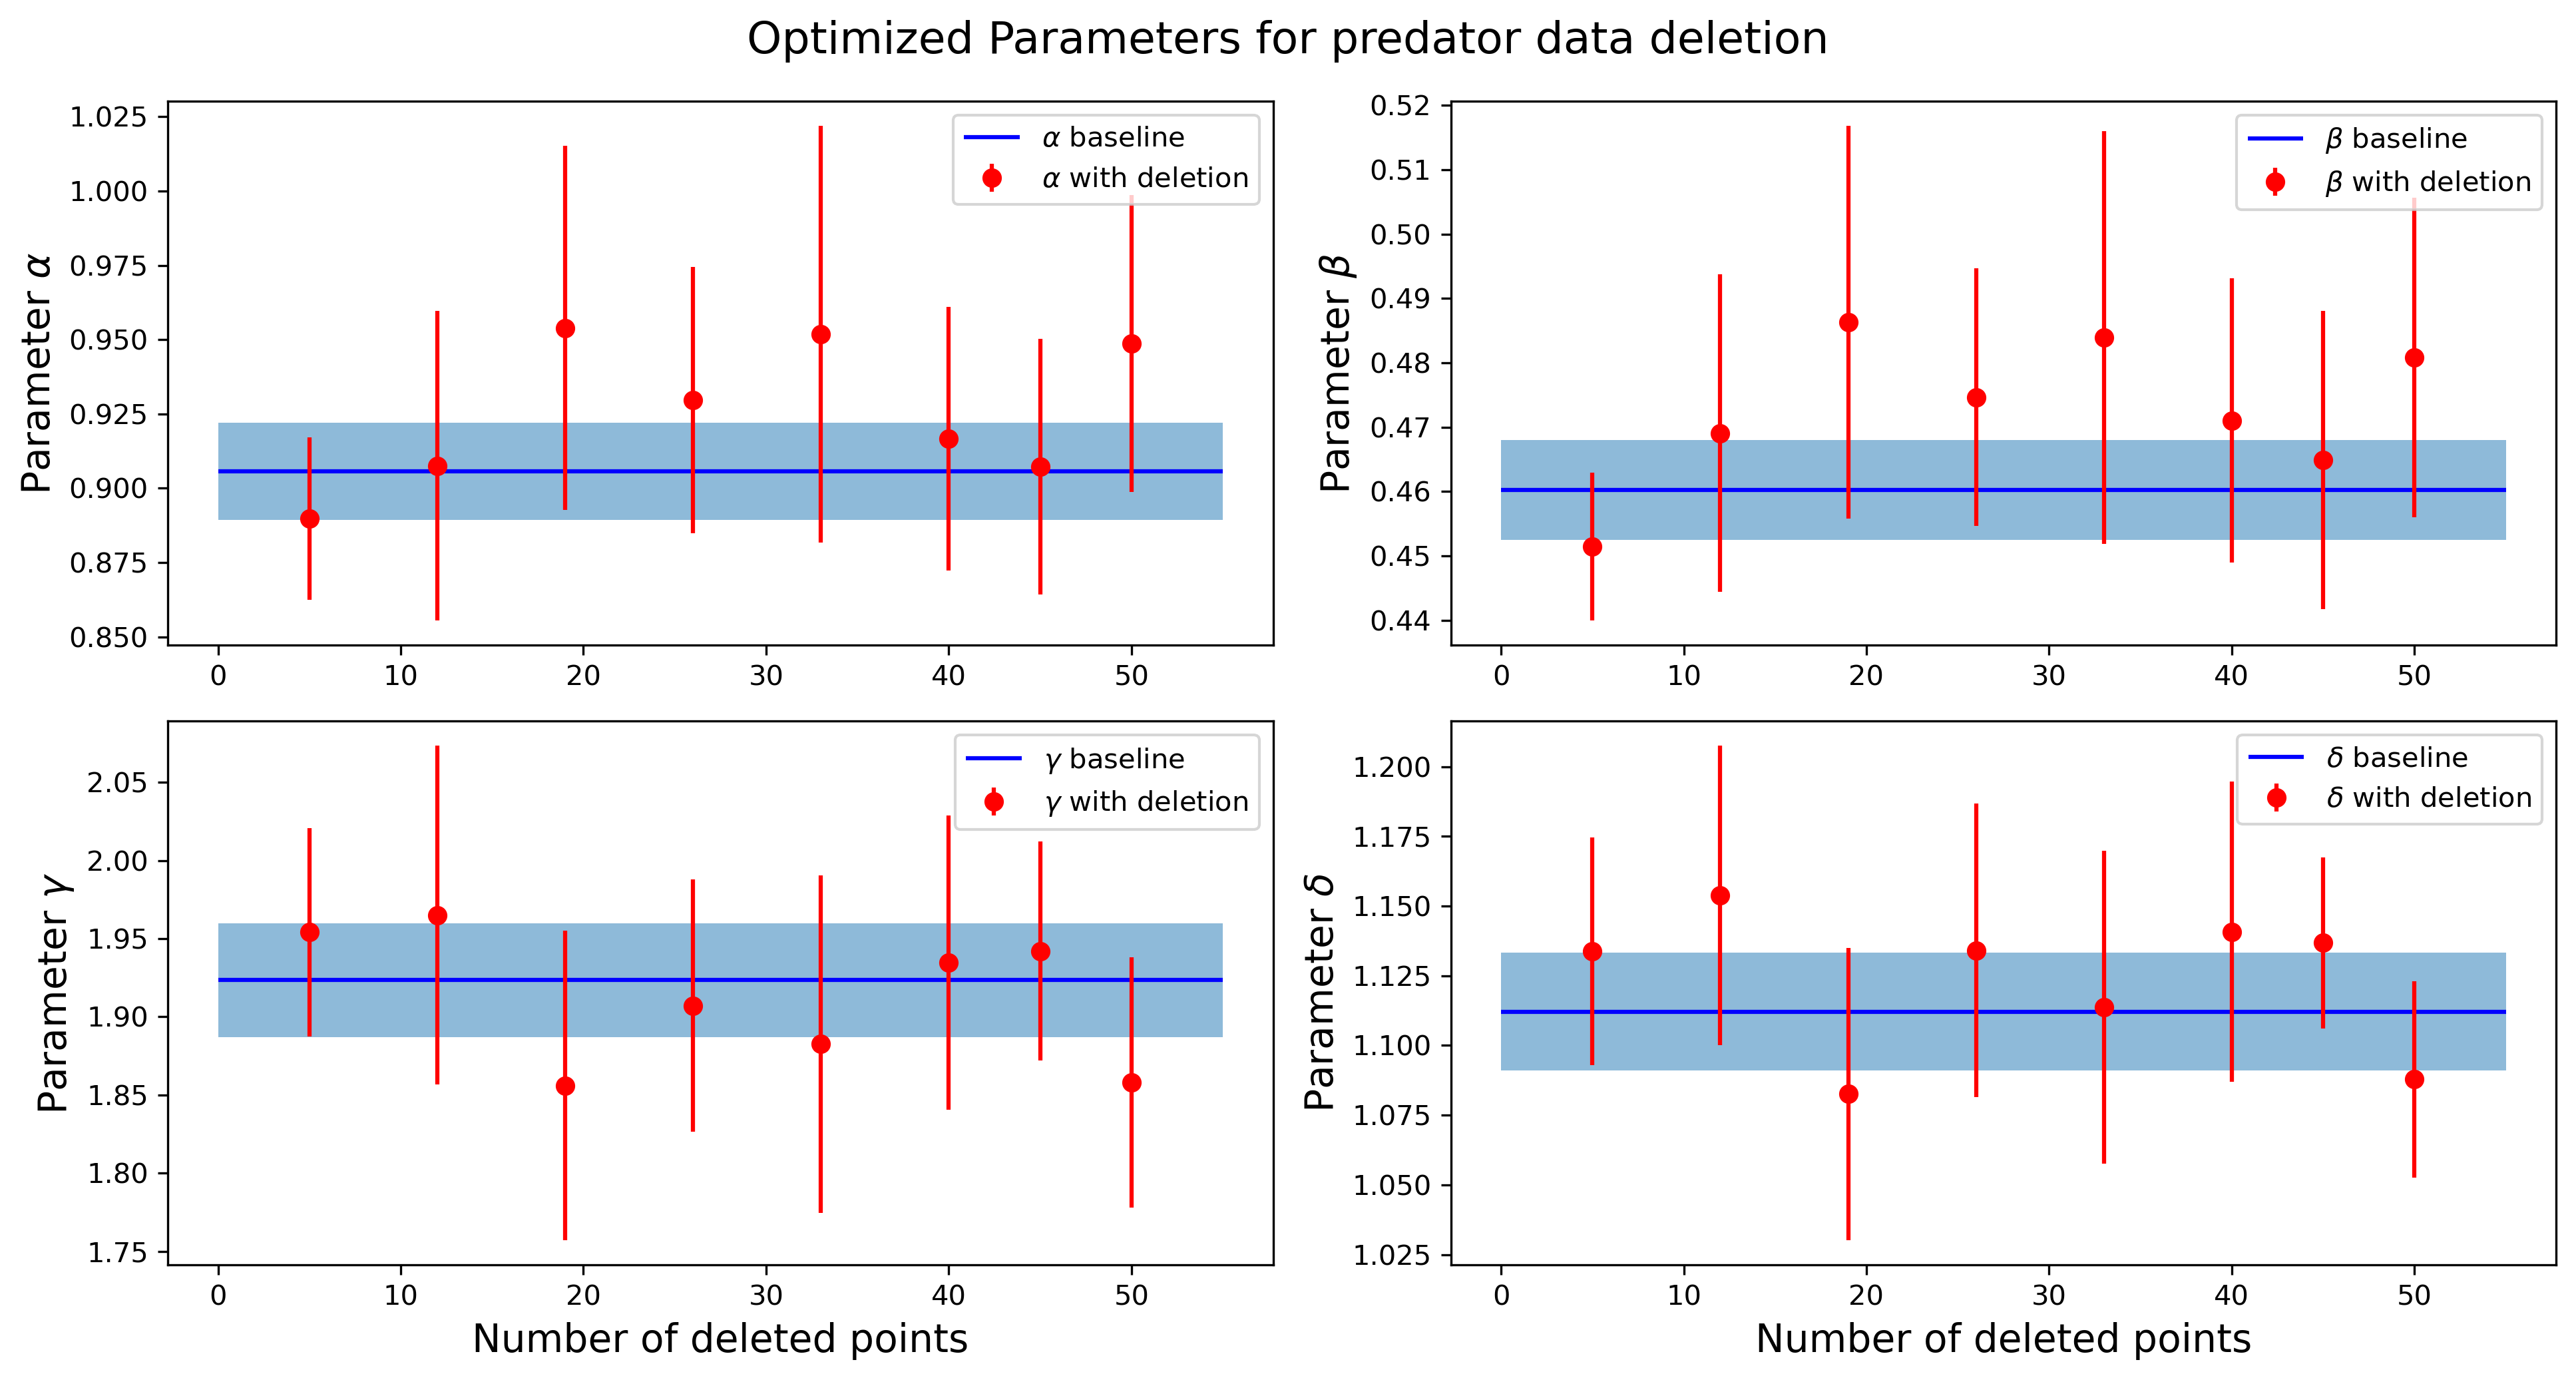

In [57]:
x_range = range(0, 56)

plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for predator data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=55, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 0], yerr=conf_params_Y_del[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=55, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 1], yerr=conf_params_Y_del[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=55, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 2], yerr=conf_params_Y_del[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=55, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_Y_del[:, 3], yerr=conf_params_Y_del[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Plotting the deletions in the prey populations vs. the baseline with all data:

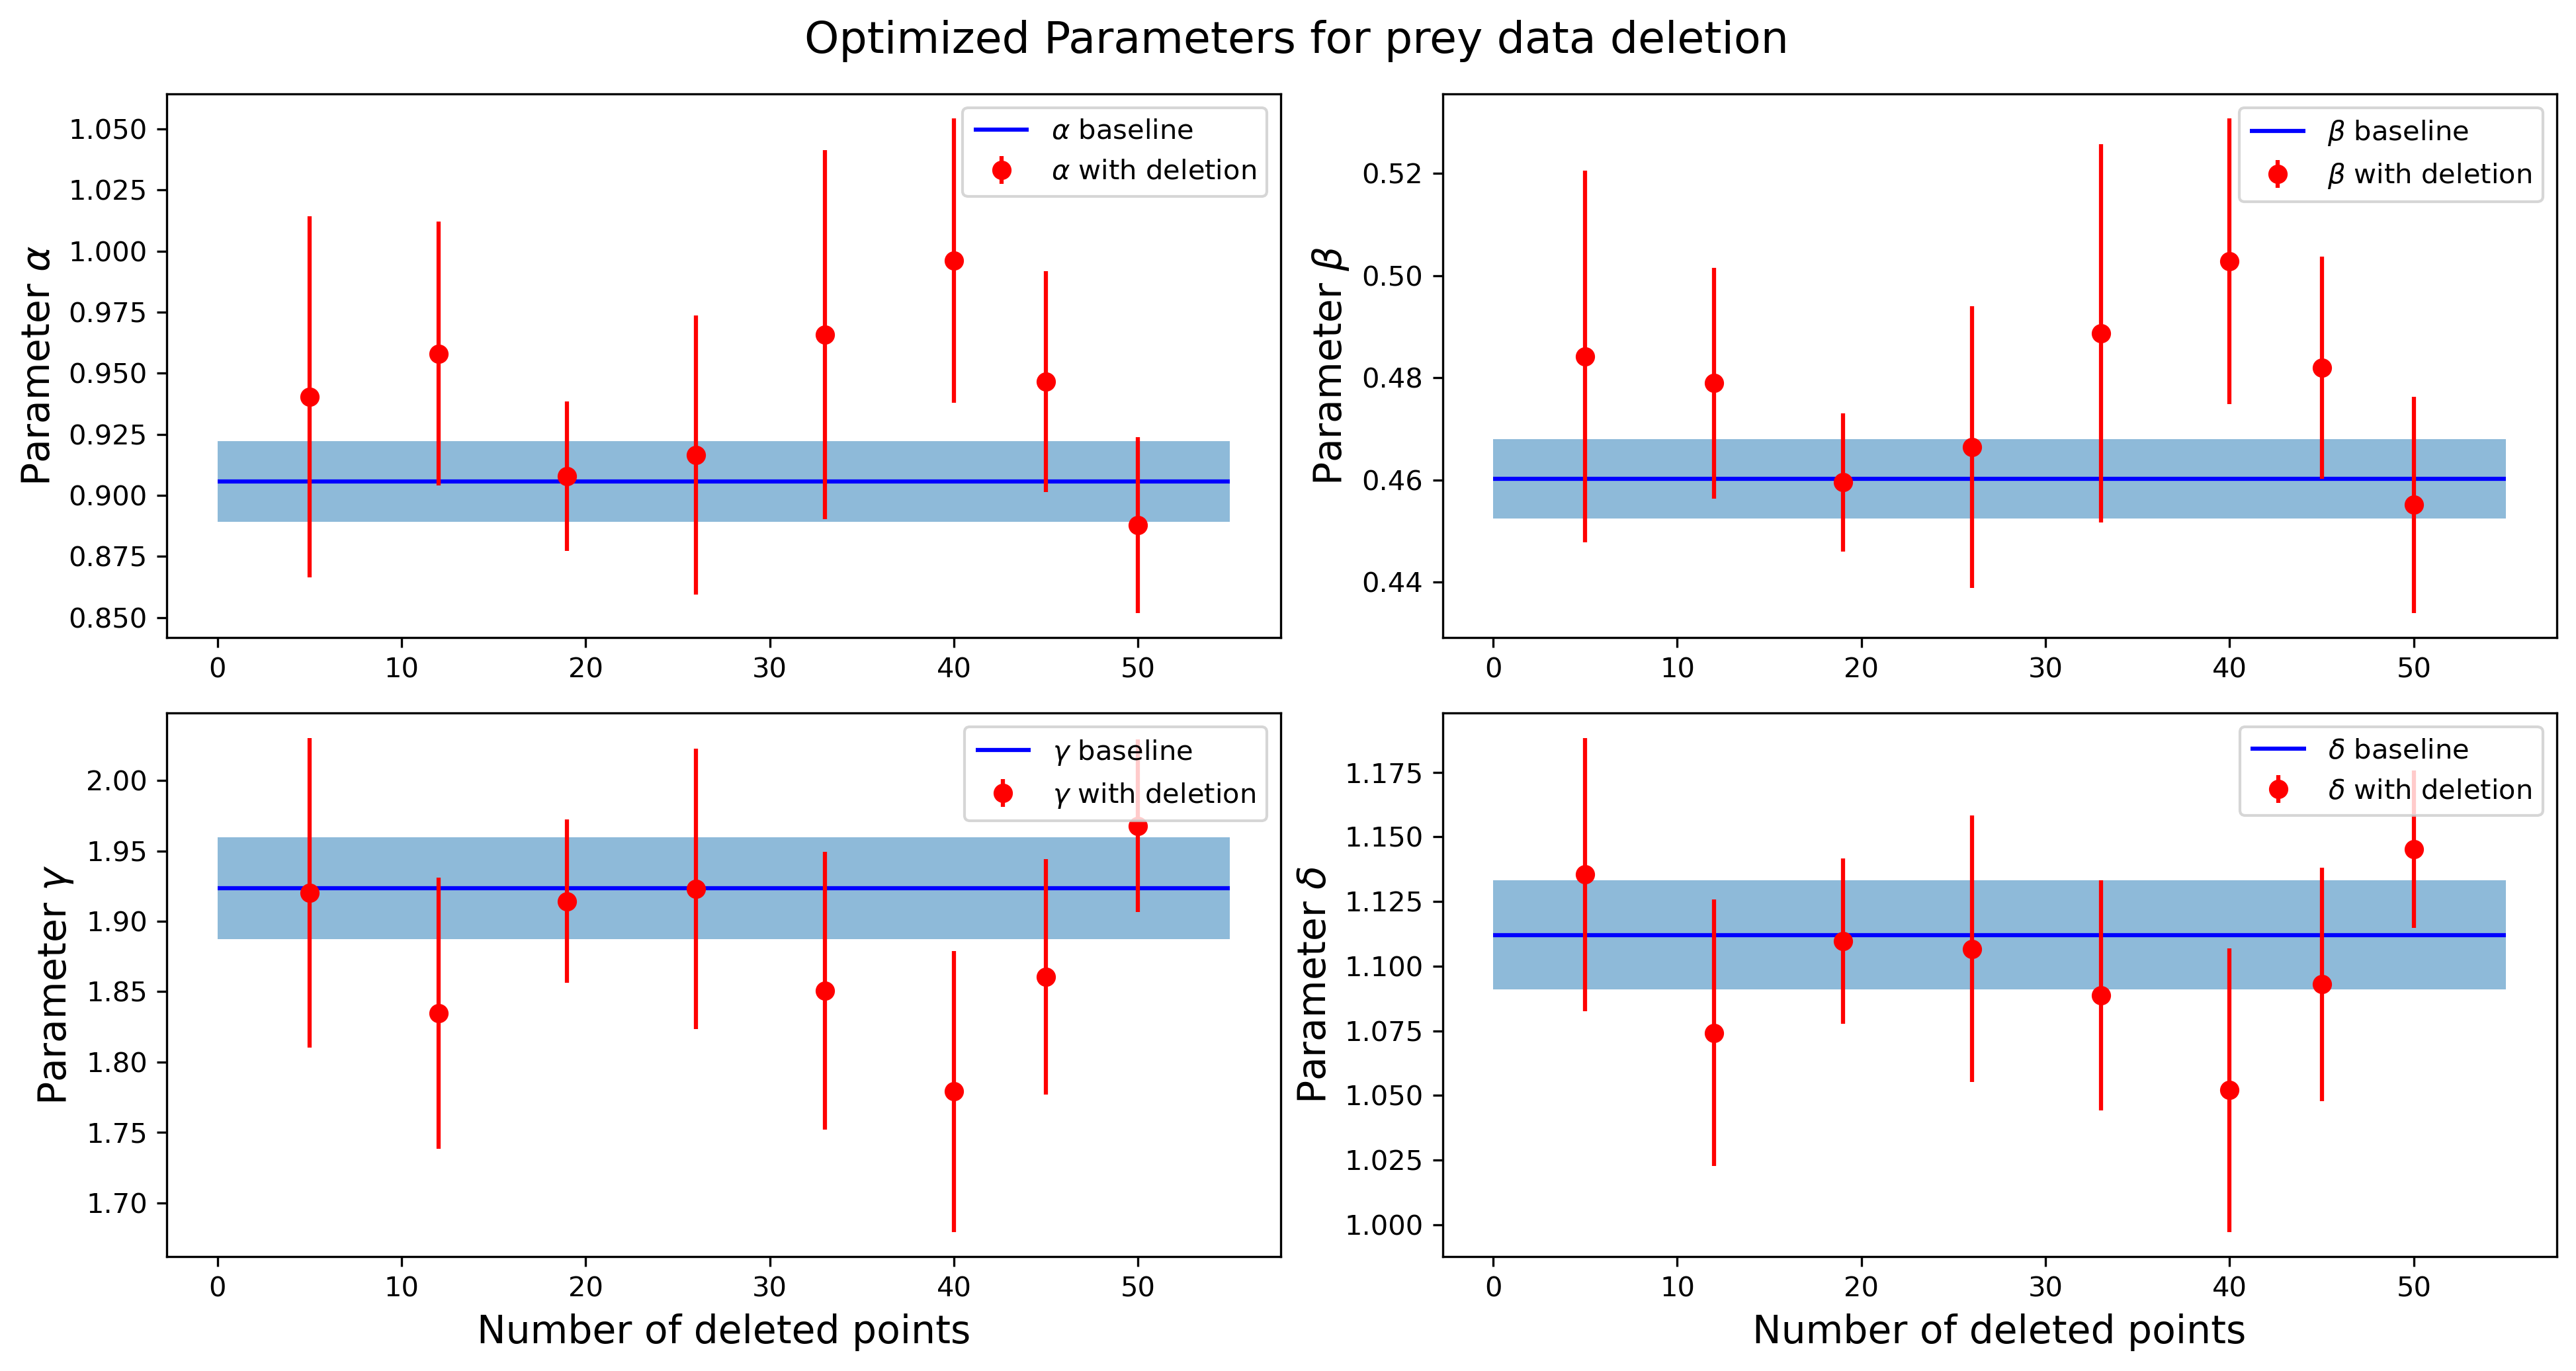

In [59]:
plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for prey data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=55, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 0], yerr=conf_params_X_del[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=55, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 1], yerr=conf_params_X_del[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=55, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 2], yerr=conf_params_X_del[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=55, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_X_del[:, 3], yerr=conf_params_X_del[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Since the above results seem to be inconclusive we compute the parameters with the combined reduced time series for multiple values of the deleted points.

In [74]:
mean_params_XY_del, conf_params_XY_del = optimization_with_deletion(num_deletions, annealing_reduced_time_series)

Plotting the combined reduced time series for multiple amounts of deleted points:

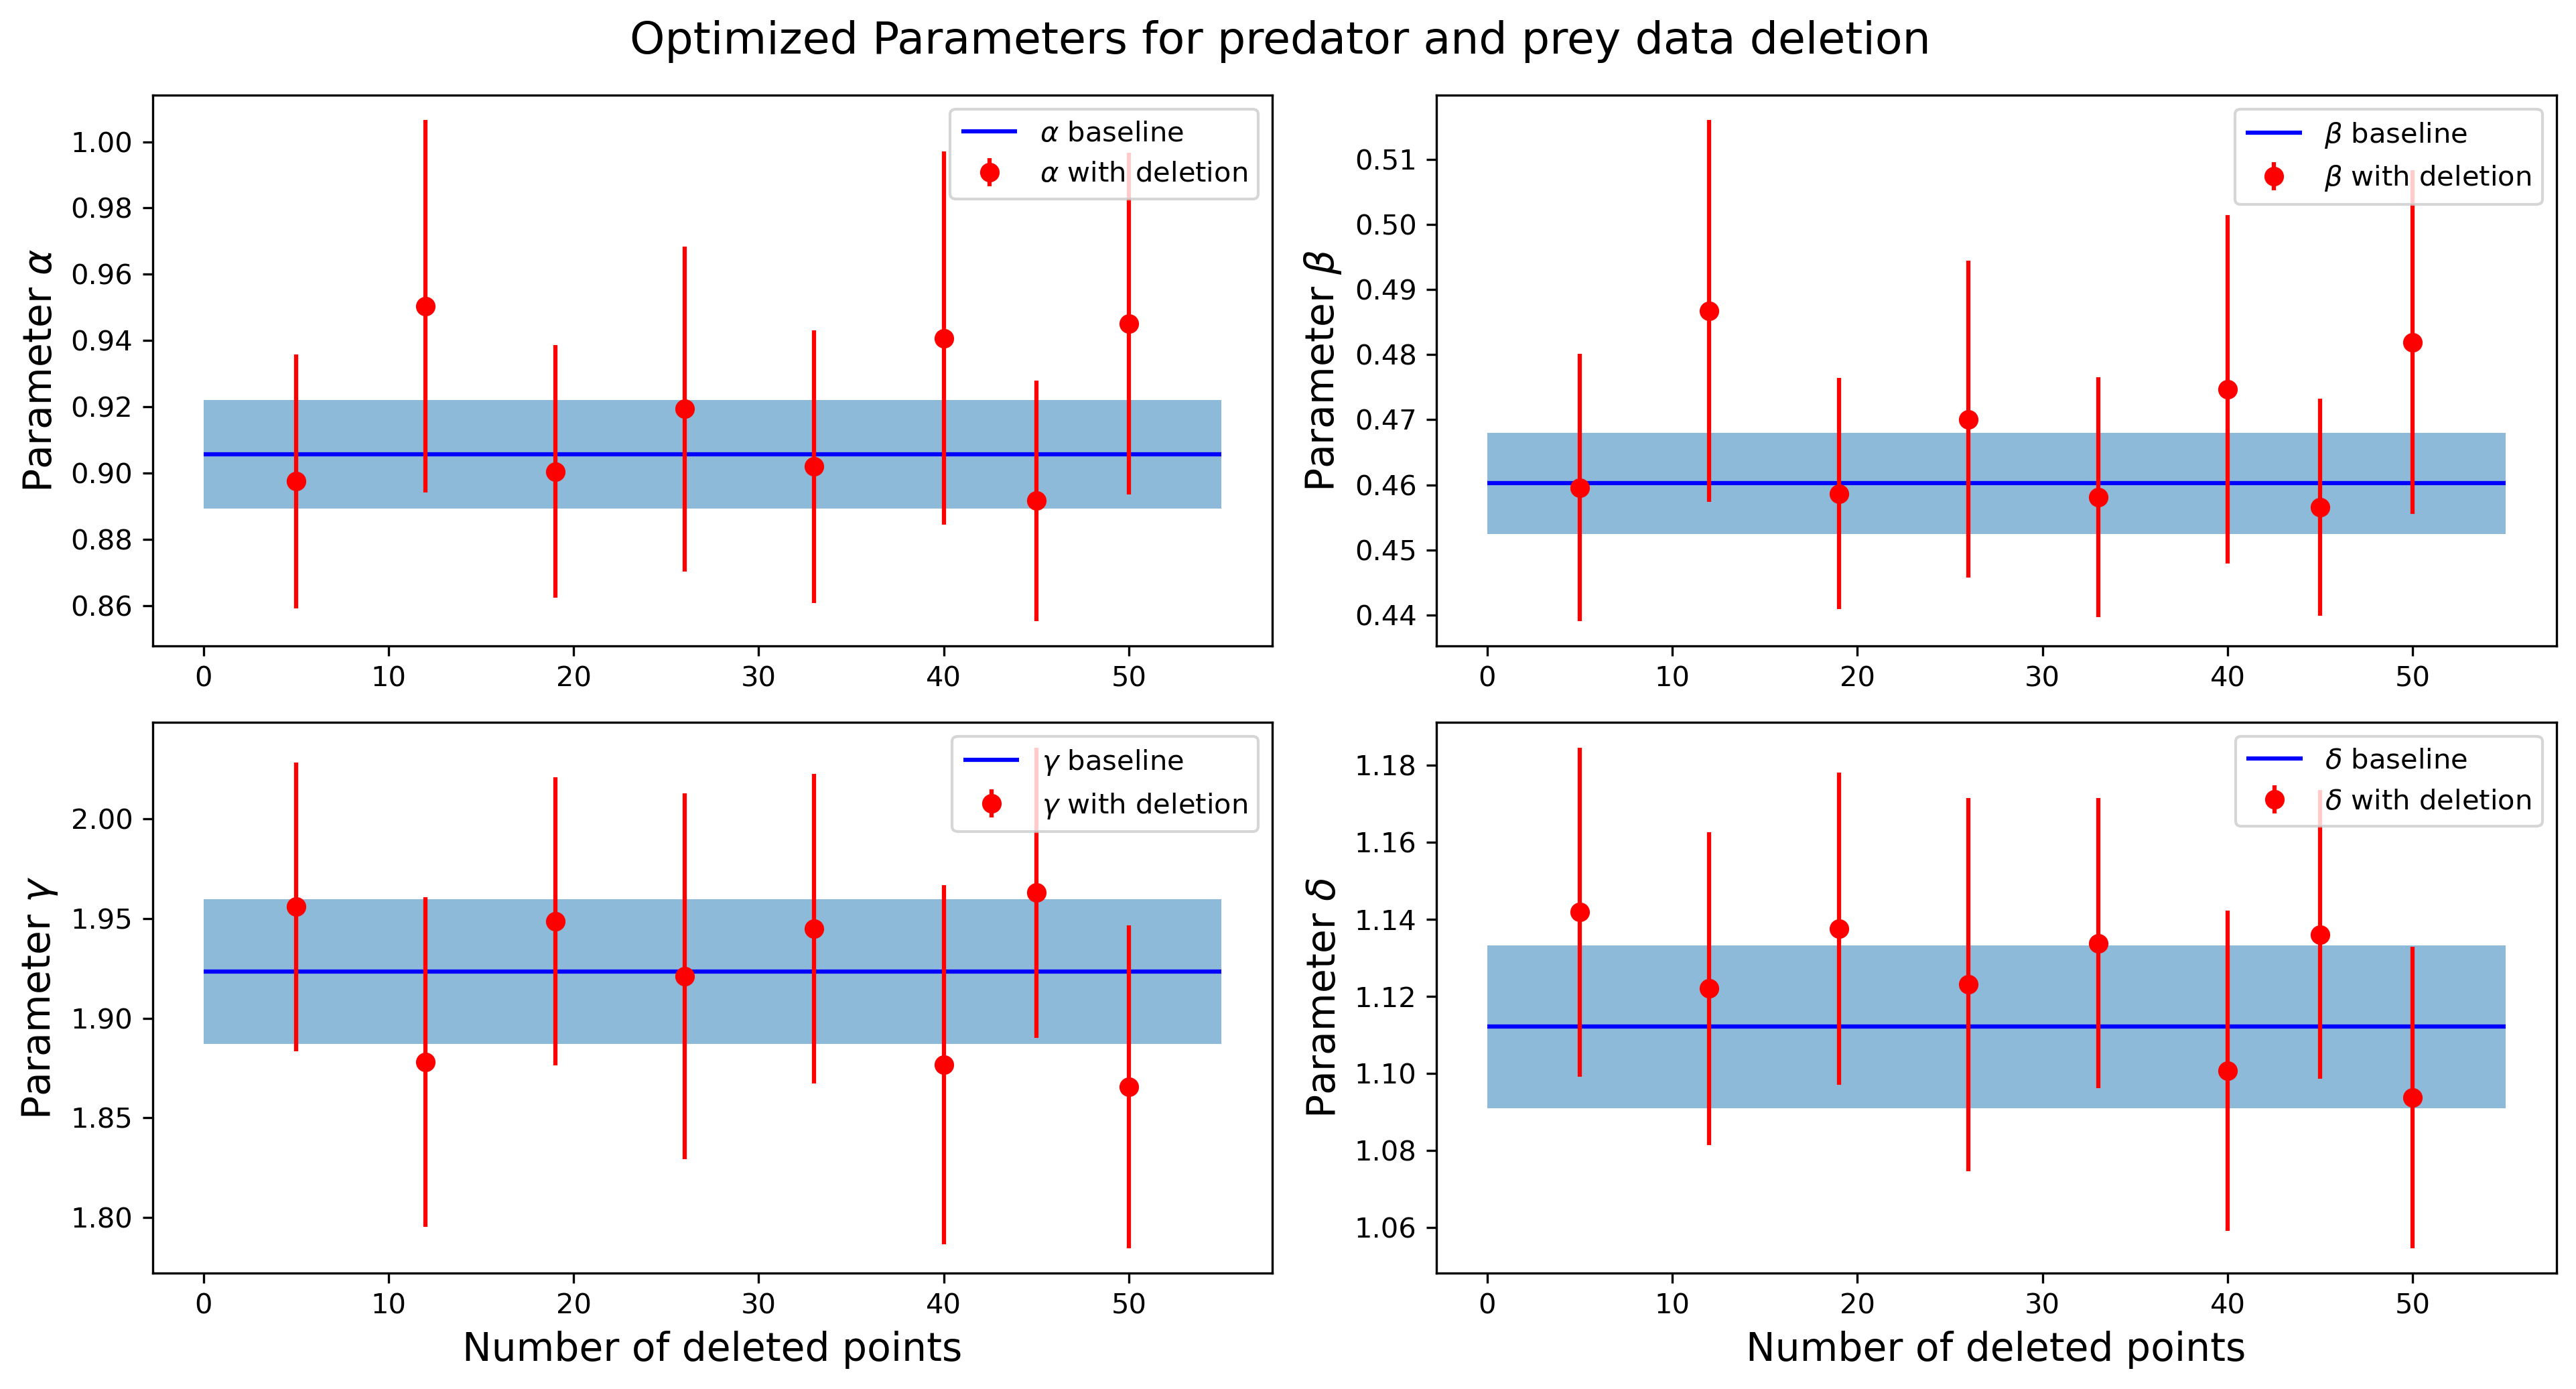

In [75]:
plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for predator and prey data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=55, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_del[:, 0], yerr=conf_params_XY_del[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=55, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_del[:, 1], yerr=conf_params_XY_del[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=55, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_del[:, 2], yerr=conf_params_XY_del[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=55, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_del[:, 3], yerr=conf_params_XY_del[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### Determining Critical Data Points for Inference Process

First, fit the Gaussian Kernel. For a single dimension, the Gaussian kernel is given by
$$
K(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
$$
For multi-dimensional data, the Gaussian kernel is given by
$$
K(x) = \frac{1}{\pi h^2}e^{-\frac{1}{2}\left(\frac{(x-X_i)^2}{h^2} + \frac{(y-Y_i)^2}{h^2} \right)}
$$

The Kernel Density Estimator is then given by
$$
f(x_g, y_g) = \frac{1}{N} \sum_{i=1}^N K(\frac{x_g - X_i}{h},\frac{y_g - Y_i}{h})
$$
Where we use $\log(f(x_g,y_g))$ for stability. Then we remove samples that have low density using importance sampling.

In [47]:
def single_density(X, bandwidth):
    """
    Compute the density estimate for single-variable data using KDE.

    Args:
        X (ndarray): Input data for a single variable (1D array).
        bandwidth (float): Bandwidth for the Gaussian kernel.

    Returns:
        ndarray: Density estimate for each data point in X.
    """
    # Reshape X to fit the sklearn KDE format (2D array with shape [n_samples, n_features])
    X = np.array(X).reshape(-1, 1)
    
    # Fit the KDE model
    kde = KernelDensity(bandwidth=bandwidth).fit(X)
    
    # Compute the density estimate for the input data
    log_density = kde.score_samples(X)
    density = np.exp(log_density)
    
    return density

def joint_density(X, Y, bandwidth):
    """
    Compute the joint density estimate for two variables using KDE.

    Args:
        X (ndarray): Input data for the first variable (1D array).
        Y (ndarray): Input data for the second variable (1D array).
        bandwidth (float): Bandwidth for the Gaussian kernel.

    Returns:
        ndarray: Joint density estimate for each data point in the joint space.
    """
    # Combine X and Y into a 2D array
    joint_data = np.vstack((X, Y)).T
    
    # Fit the KDE model
    kde = KernelDensity(bandwidth=bandwidth).fit(joint_data)
    
    # Compute the density estimate for the joint data
    log_density = kde.score_samples(joint_data)
    joint_density = np.exp(log_density)
    
    return joint_density

In [79]:
prey_density = single_density(X_data, bandwidth=0.5)

# Joint density for predator-prey populations
predator_prey_density = joint_density(X_data, Y_data, bandwidth=0.5)

# Print the first few density values
print("Single density (Prey):", prey_density[:5])
print("Joint density (Predator-Prey):", predator_prey_density[:5])

Single density (Prey): [0.13936439 0.17911862 0.31083708 0.42148485 0.42430414]
Joint density (Predator-Prey): [0.0230901  0.0328974  0.04018153 0.03349211 0.03520838]


In [22]:
def sheather_jones_bandwidth(data):
    """Estimate bandwidth for univariate kernels using the Sheather-Jones method. A dummy Gaussian kernel is used to compute the second derivative.

    Args:
        data (array): datapoints

    Returns:
        float: bandwidth
    """    
    n = len(data)
    data_std = np.std(data, ddof=1)

    # Pilot bandwidth using normal reference rule
    h0 = 1.06 * data_std * n ** (-1 / 5)

    # Generate evaluation points
    x_min, x_max = np.min(data), np.max(data)
    x_eval = np.linspace(x_min - 3 * data_std, x_max + 3 * data_std, 1000)

    # Density estimation using pilot bandwidth h0
    kde = stats.gaussian_kde(data, bw_method=h0 / data_std)
    f_hat = kde.evaluate(x_eval)

    # Second derivative of Gaussian kernel
    def gaussian_second_derivative(u):
        return (u**2 - 1) * np.exp(-u**2 / 2) / np.sqrt(2 * np.pi)

    # Estimate the second derivative of the density
    fpp_hat = np.zeros_like(x_eval)
    for i, x in enumerate(x_eval):
        u = (x - data) / h0
        fpp_hat[i] = np.sum(gaussian_second_derivative(u)) / (n * h0**3)

    # Compute R(f'')
    R_fpp = np.trapz(fpp_hat**2, x_eval)

    # Constants for Gaussian kernel
    R_k = 1 / (2 * np.sqrt(np.pi))
    mu2_k = 1

    # Compute the Sheather-Jones bandwidth h_SJ
    h_SJ = (R_k / (mu2_k**2 * R_fpp * n)) ** (1 / 5)

    return h_SJ


Computed Sheather-Jones bandwidth h: 0.294297


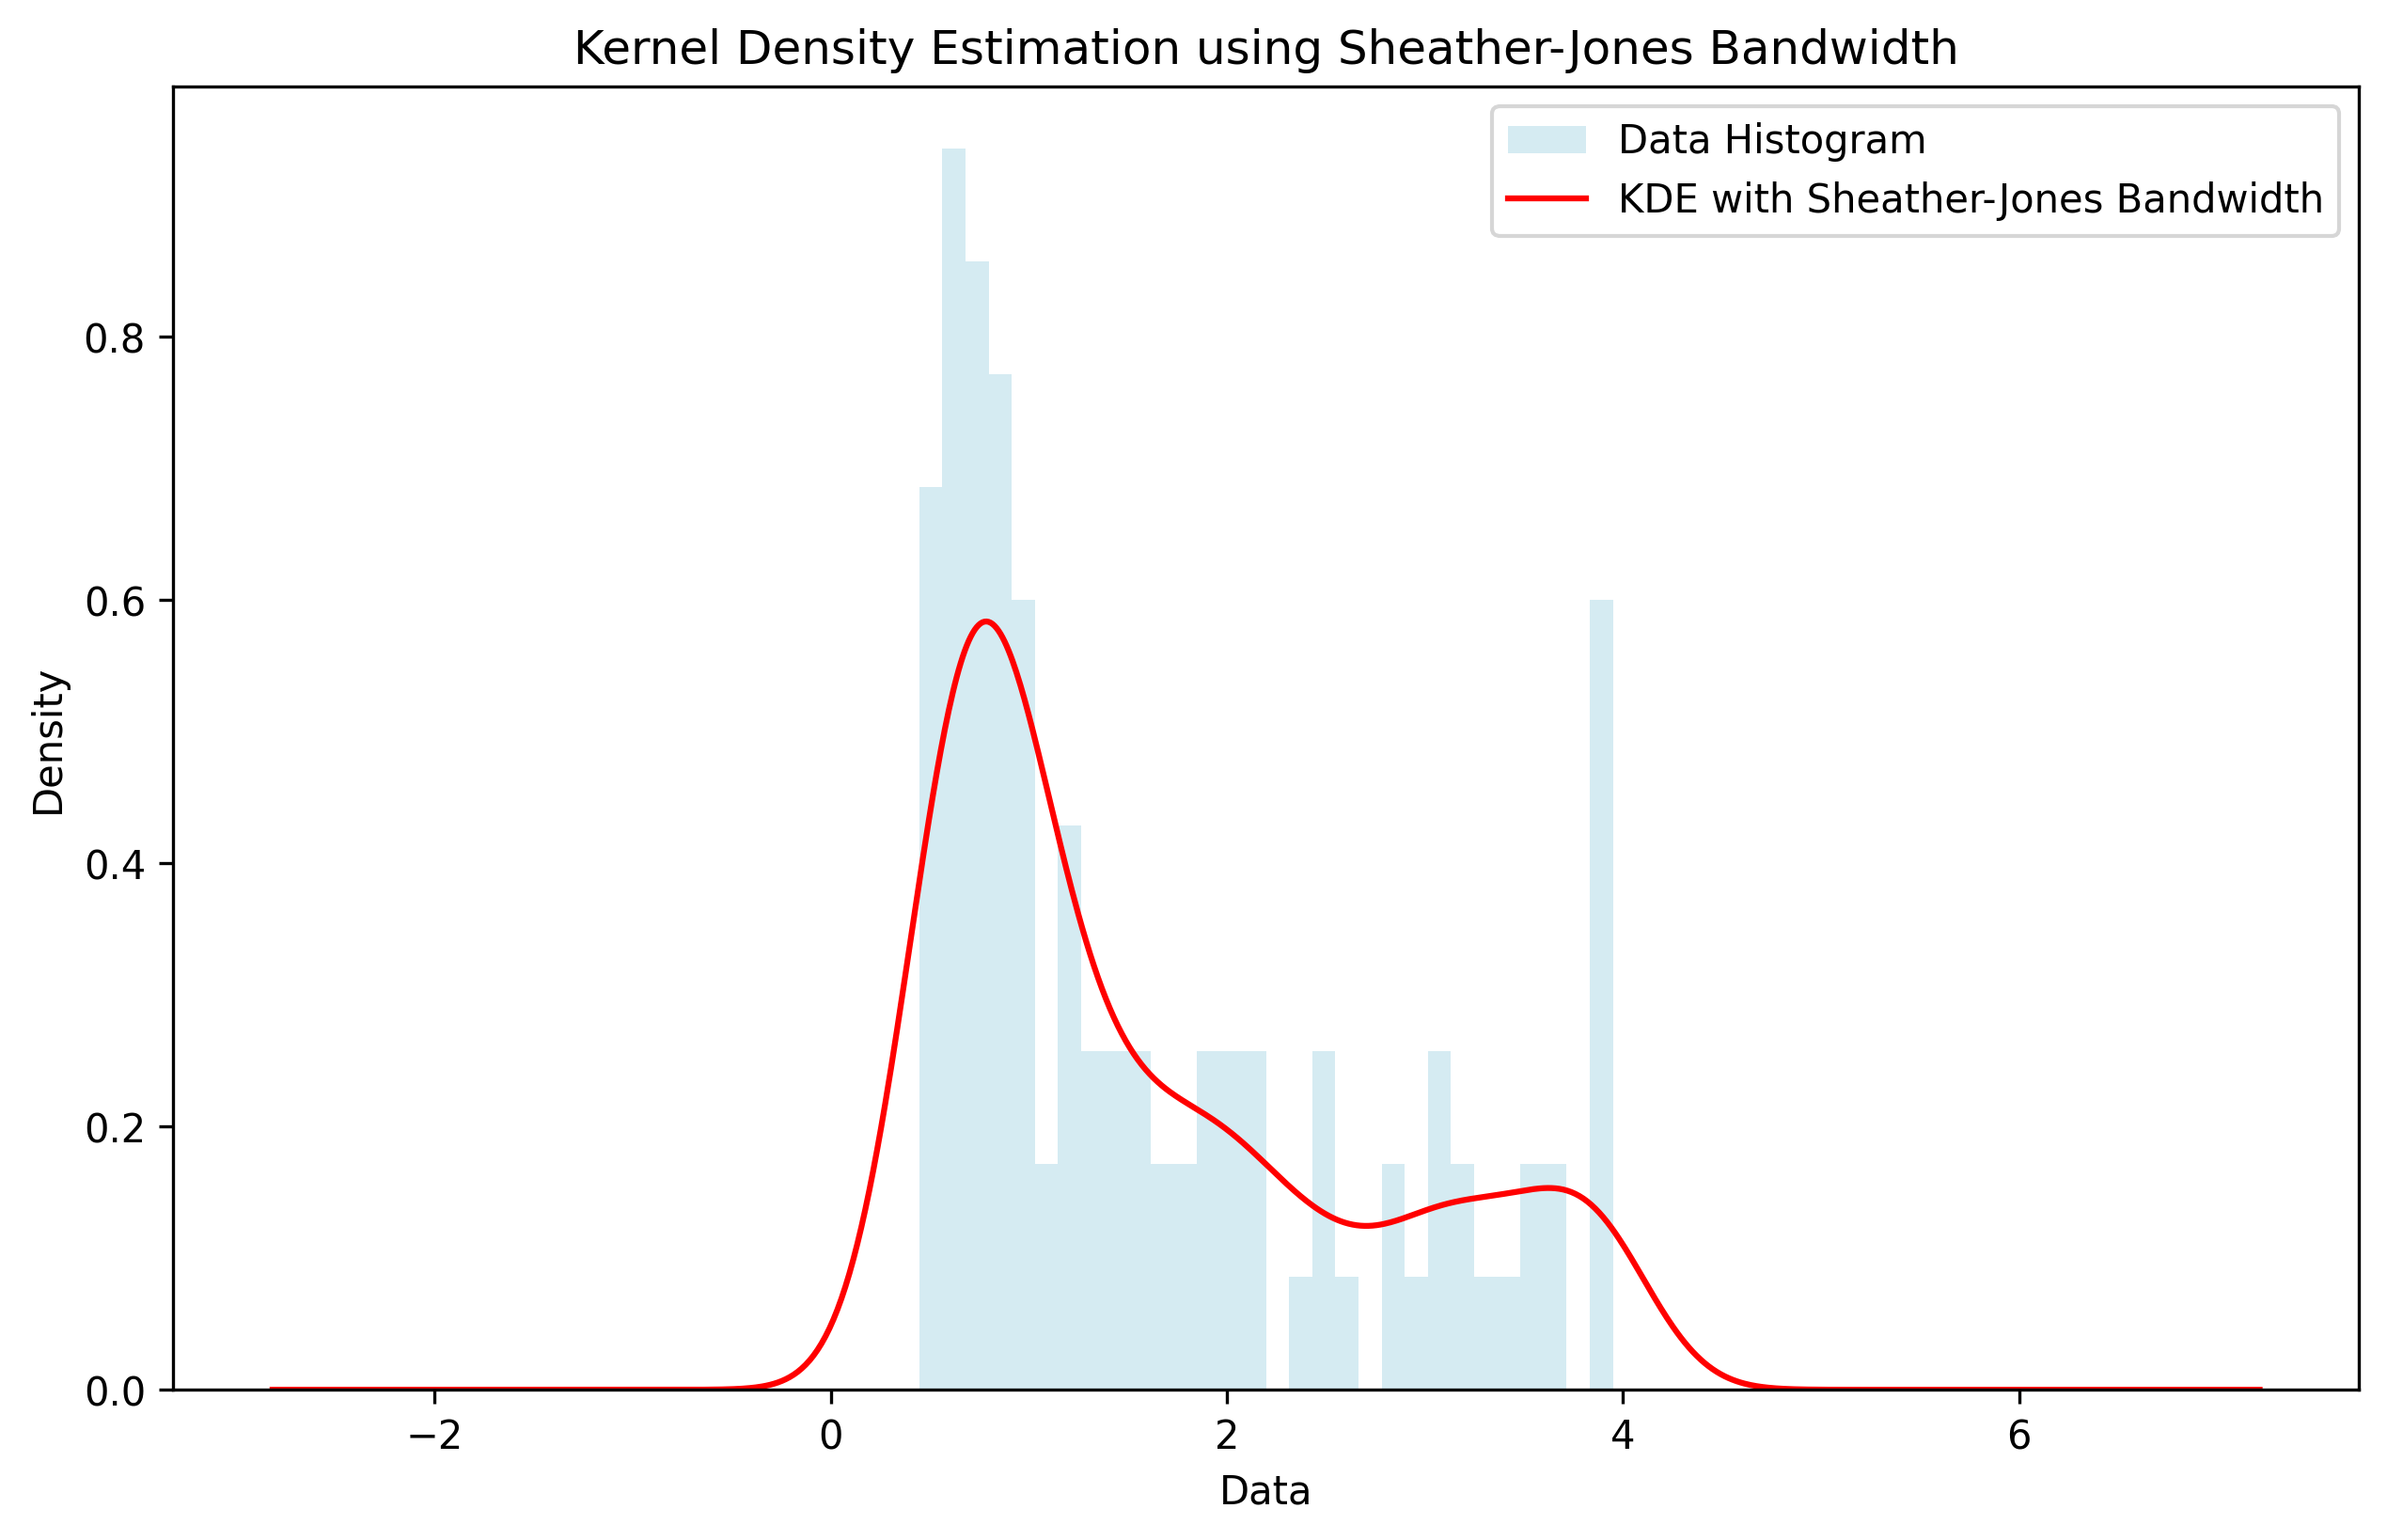

In [ ]:
# Compute the Sheather-Jones bandwidth for X
data = np.array(X_data) 
h_sj = sheather_jones_bandwidth(data)
print(f"Computed Sheather-Jones bandwidth h: {h_sj:.6f}")

# Perform KDE using the computed bandwidth
kde_sj = stats.gaussian_kde(data, bw_method=h_sj / np.std(data, ddof=1))

# Generate points where KDE will be evaluated
x_grid = np.linspace(np.min(data) - 3 * np.std(data, ddof=1),
                     np.max(data) + 3 * np.std(data, ddof=1), 1000)

# Evaluate the KDE
density = kde_sj.evaluate(x_grid)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, color='lightblue', label='Data Histogram')
plt.plot(x_grid, density, 'r-', label='KDE with Sheather-Jones Bandwidth')
plt.title('Kernel Density Estimation for Prey Data using Sheather-Jones Bandwidth')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

Computed Sheather-Jones bandwidth h: 0.495155


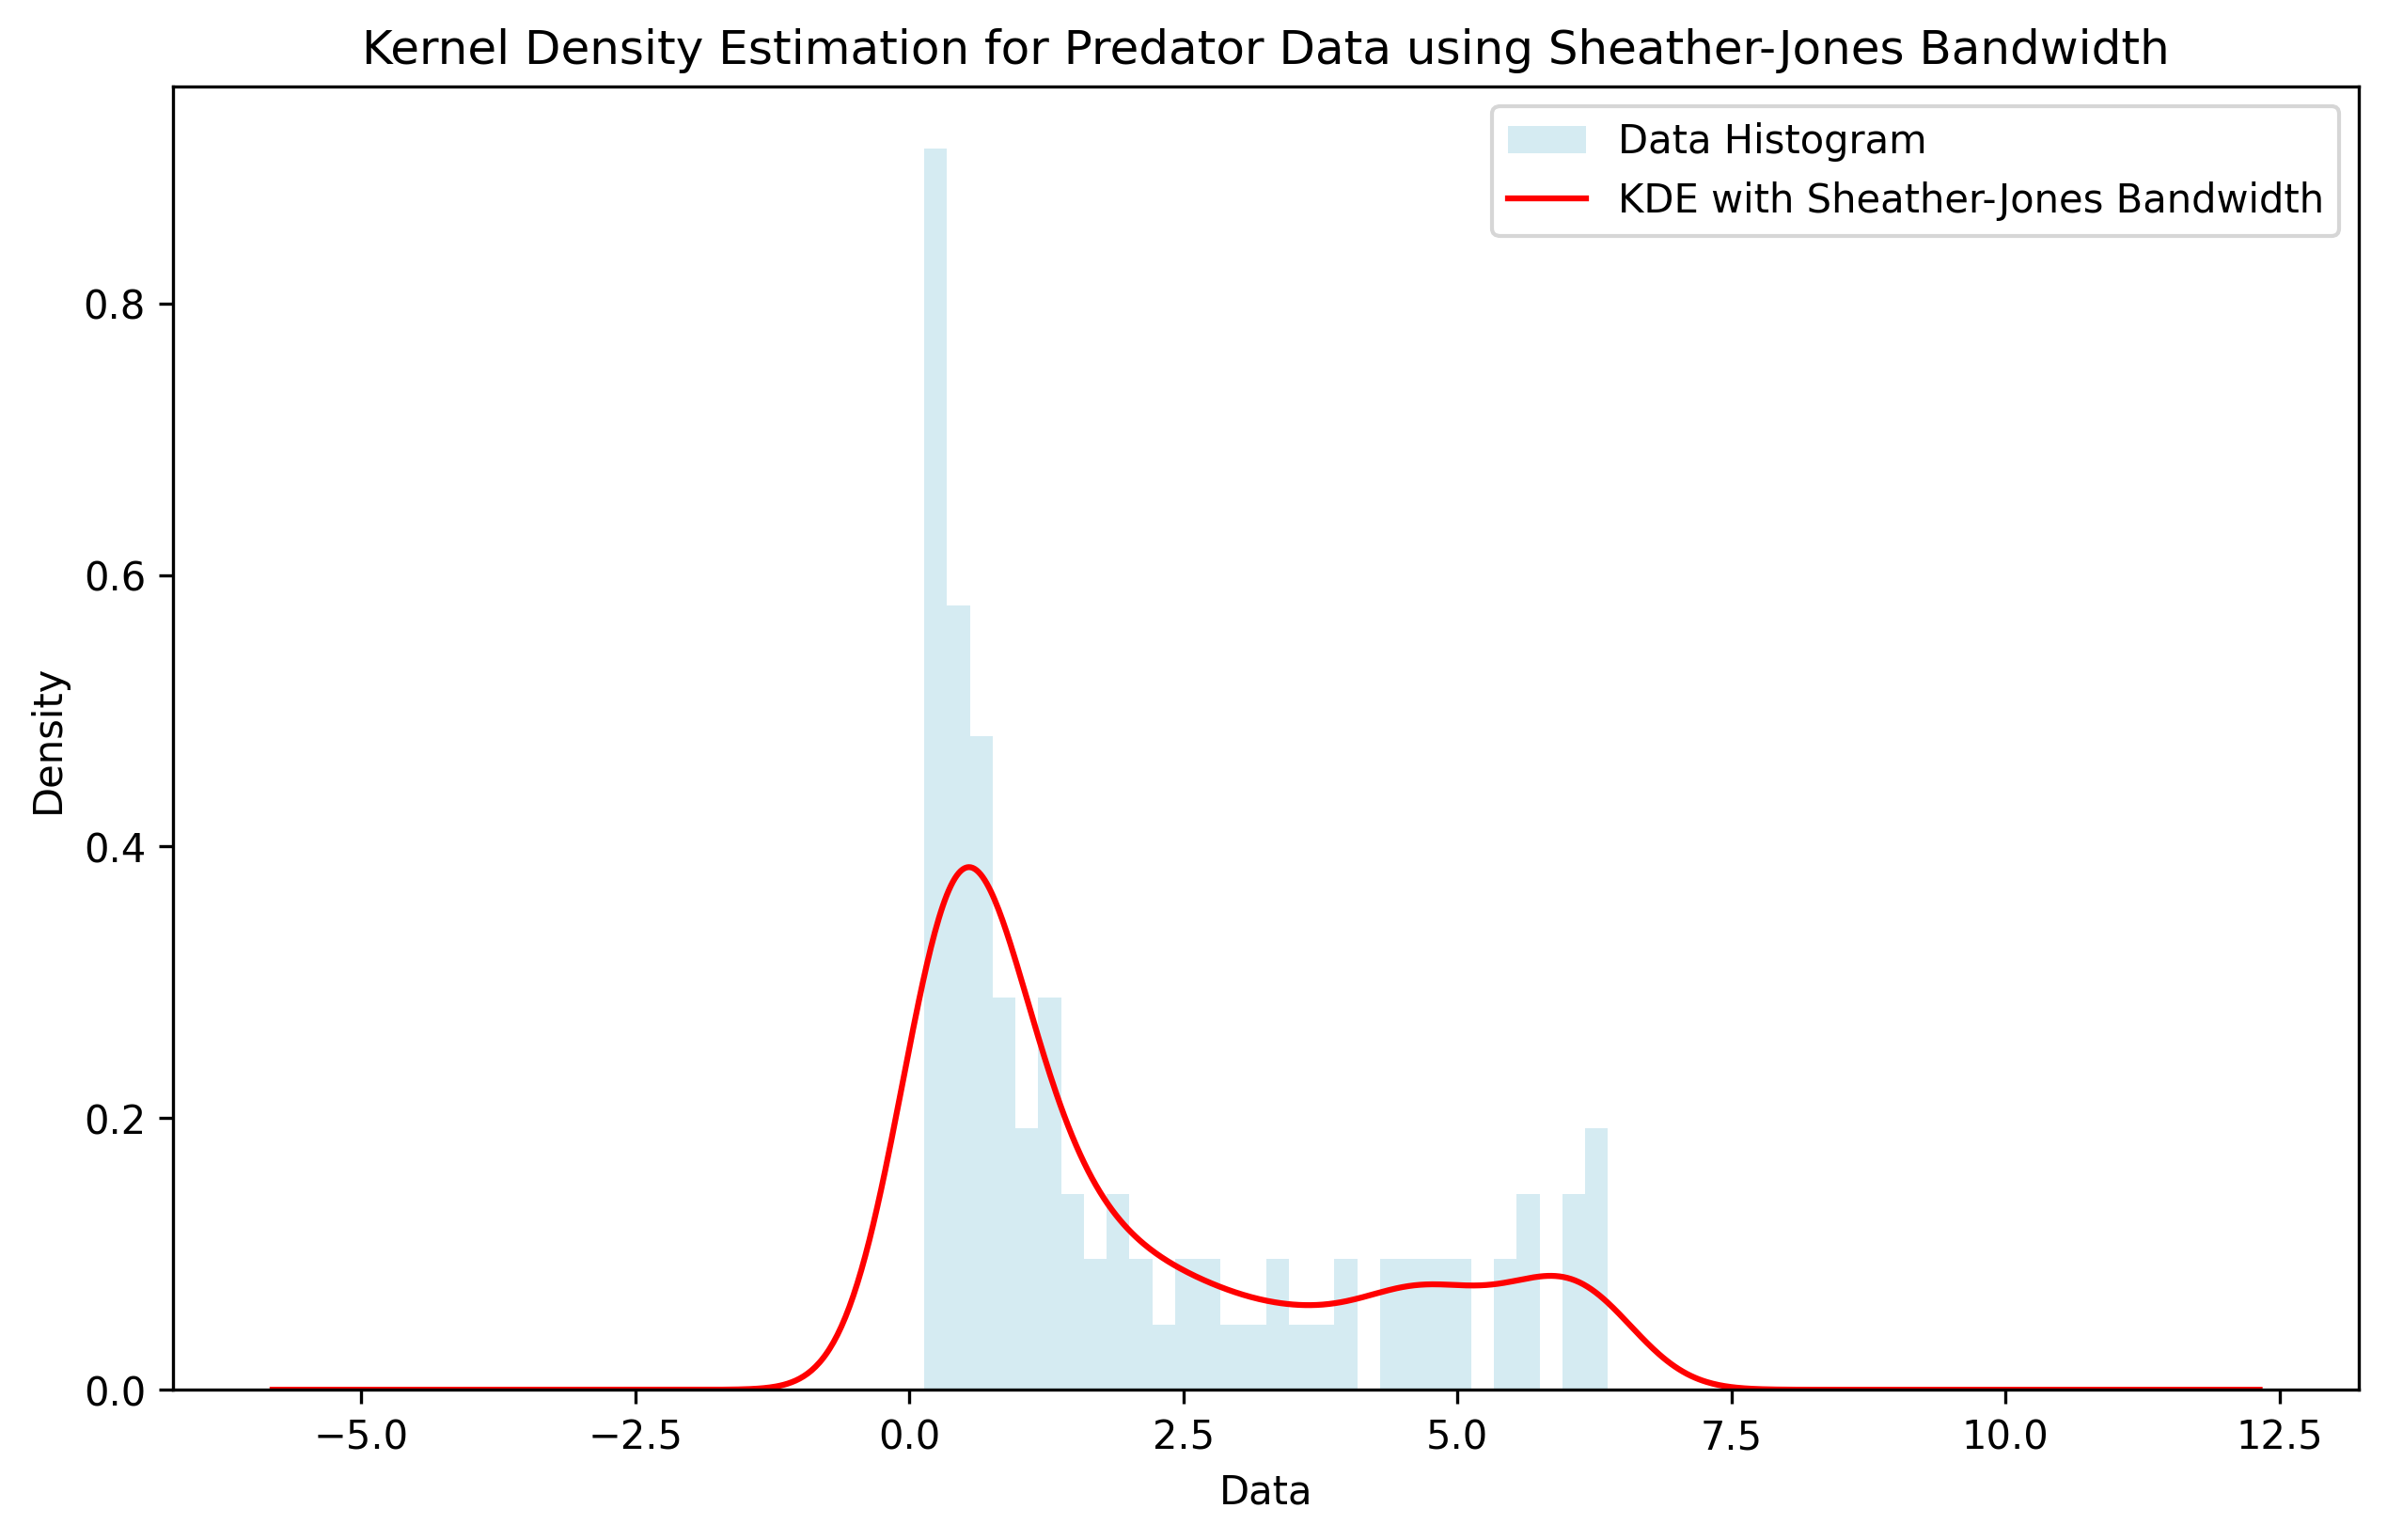

In [45]:
# Compute the Sheather-Jones bandwidth for X
data = np.array(Y_data) 
h_sj = sheather_jones_bandwidth(data)
print(f"Computed Sheather-Jones bandwidth h: {h_sj:.6f}")

# Perform KDE using the computed bandwidth
kde_sj = stats.gaussian_kde(data, bw_method=h_sj / np.std(data, ddof=1))

# Generate points where KDE will be evaluated
x_grid = np.linspace(np.min(data) - 3 * np.std(data, ddof=1),
                     np.max(data) + 3 * np.std(data, ddof=1), 1000)

# Evaluate the KDE
density = kde_sj.evaluate(x_grid)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, color='lightblue', label='Data Histogram')
plt.plot(x_grid, density, 'r-', label='KDE with Sheather-Jones Bandwidth')
plt.title('Kernel Density Estimation for Predator Data using Sheather-Jones Bandwidth')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

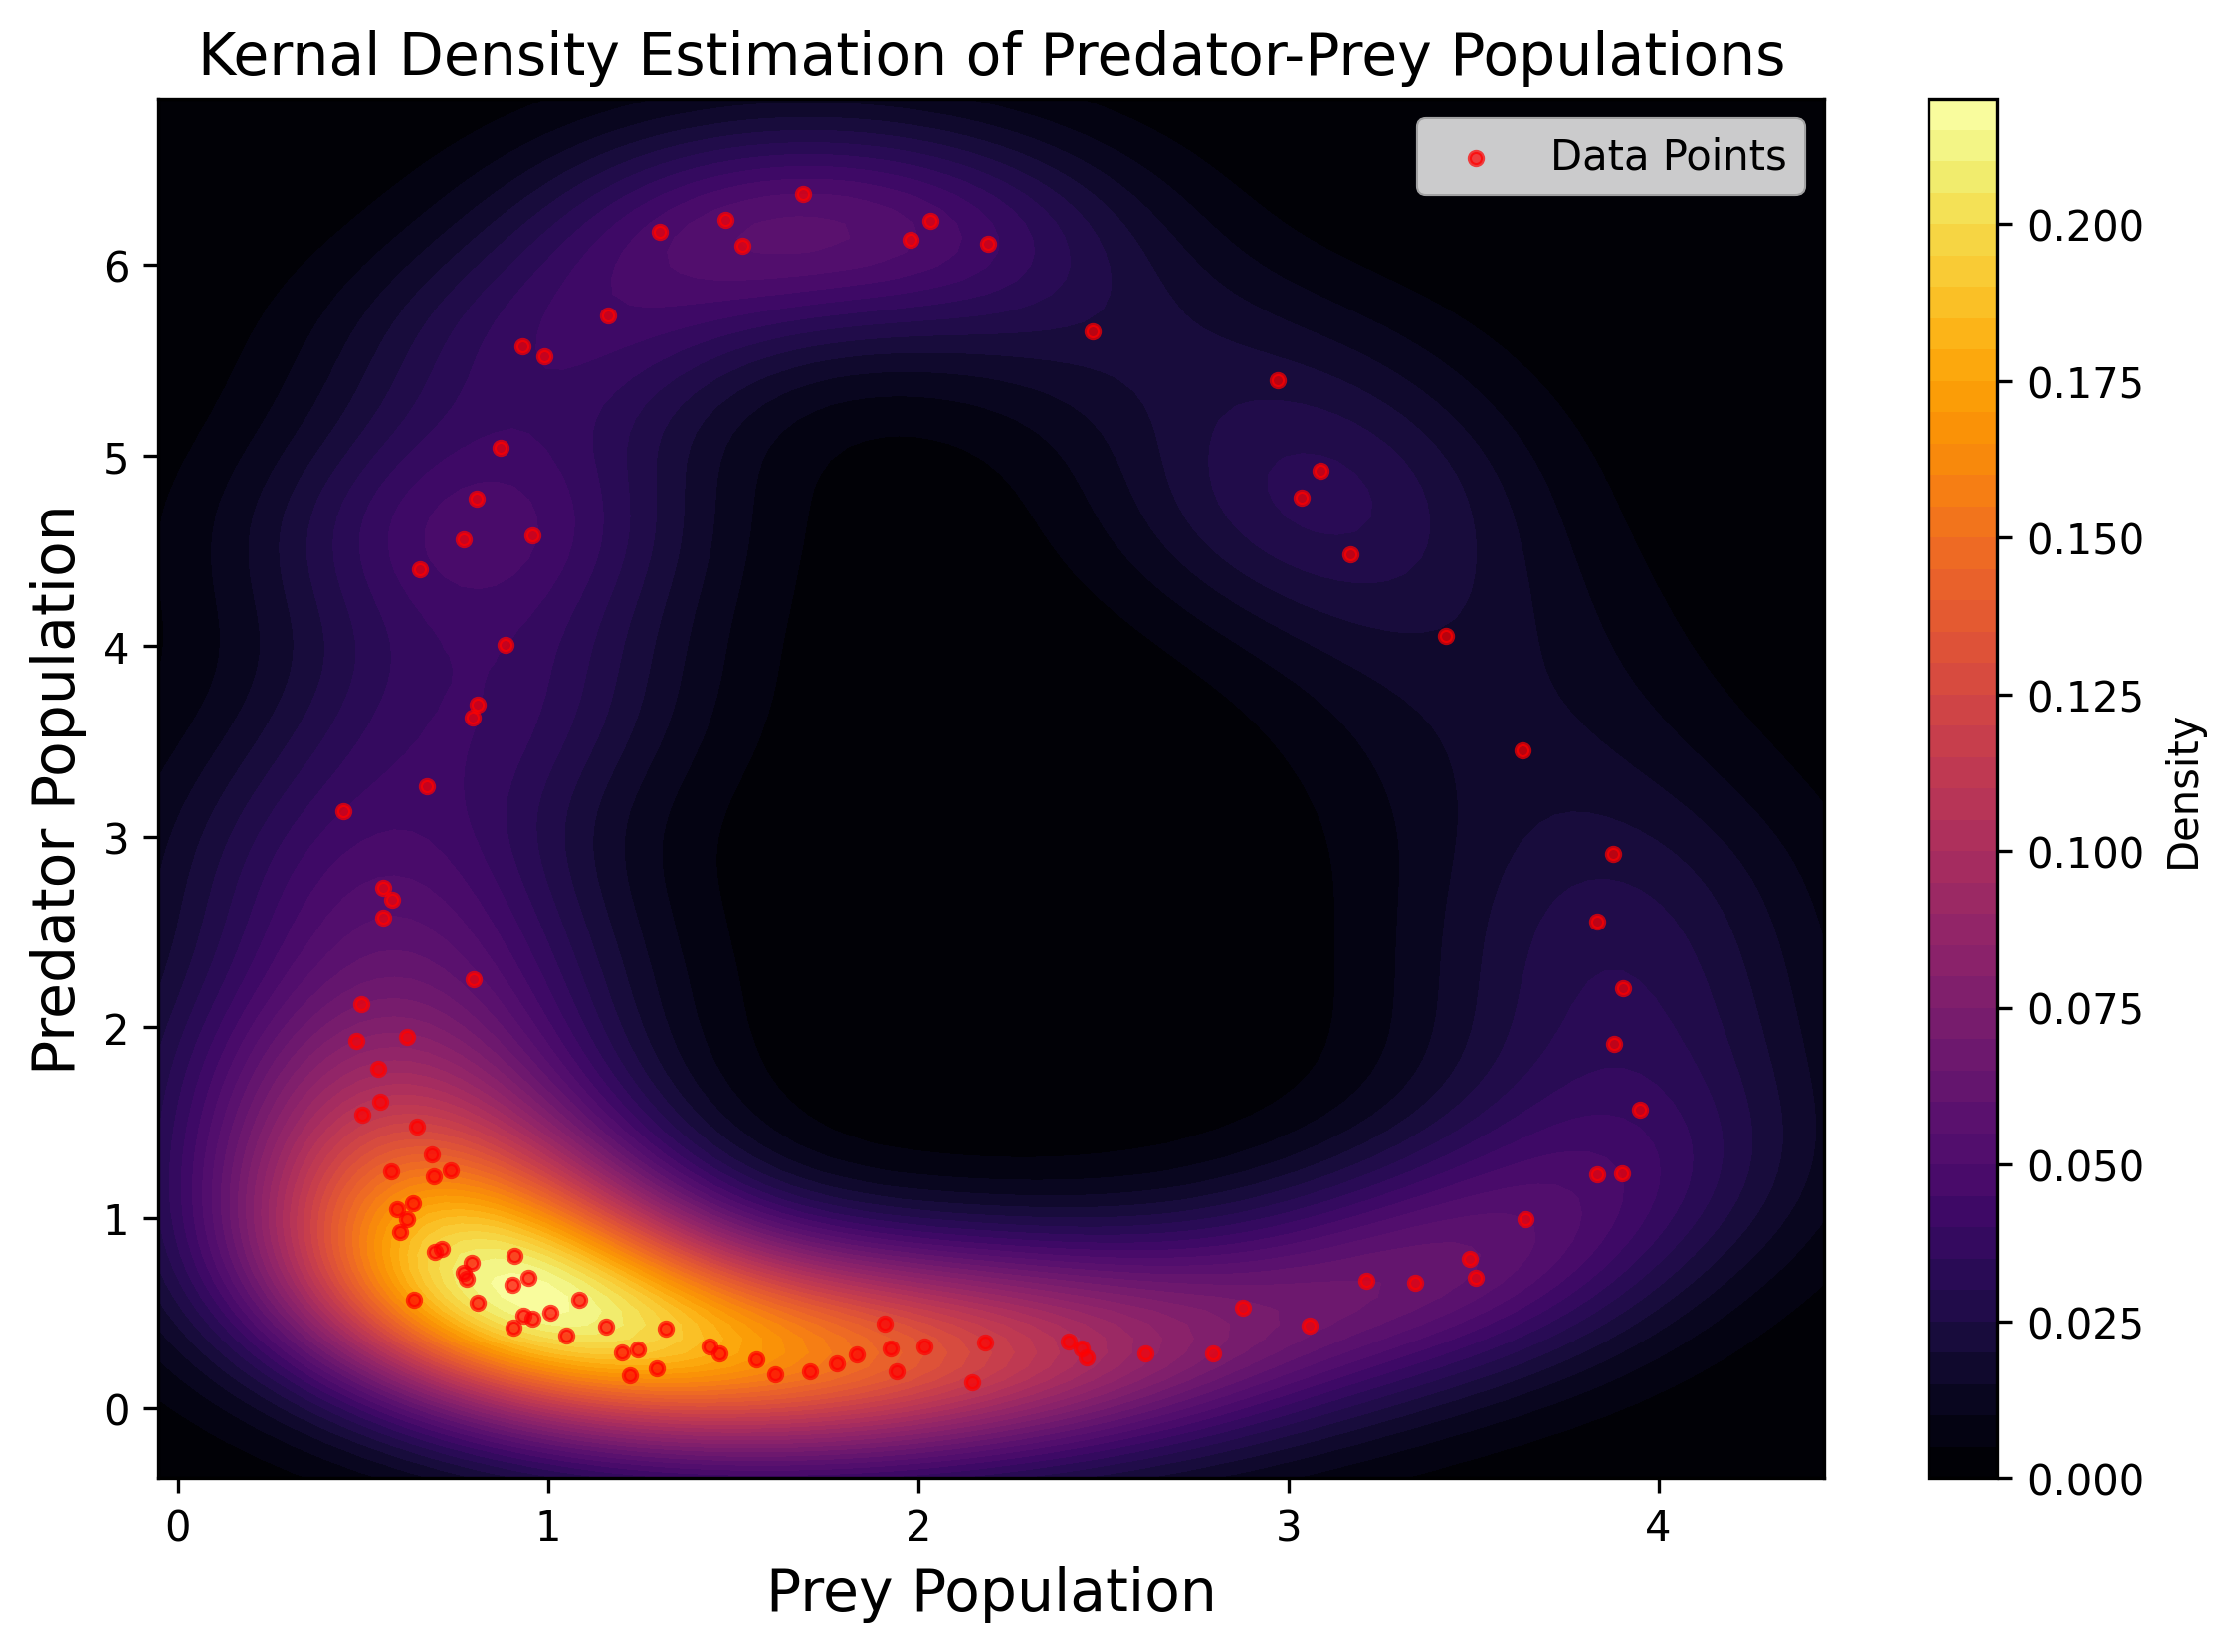

In [44]:
x_grid = np.linspace(X_data.min() - 0.5, X_data.max() + 0.5, 100)
y_grid = np.linspace(Y_data.min() - 0.5, Y_data.max() + 0.5, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Combine grid points for KDE evaluation
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

# Fit KDE for joint density
joint_data = np.vstack((X_data, Y_data)).T
kde = KernelDensity(bandwidth=(0.495155+0.294297)/2).fit(joint_data)
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(X_grid.shape)

# Plot the joint density as a contour plot
plt.figure(figsize=(9, 6))
plt.title("Kernal Density Estimation of Predator-Prey Populations", fontsize=14)
plt.contourf(X_grid, Y_grid, density, levels=50, cmap="inferno")
plt.colorbar(label="Density")

# Overlay the original data points
plt.scatter(X_data, Y_data, color="red", s=10, alpha=0.7, label="Data Points")

plt.xlabel("Prey Population", fontsize=14)
plt.ylabel("Predator Population", fontsize=14)
plt.legend()
plt.show()

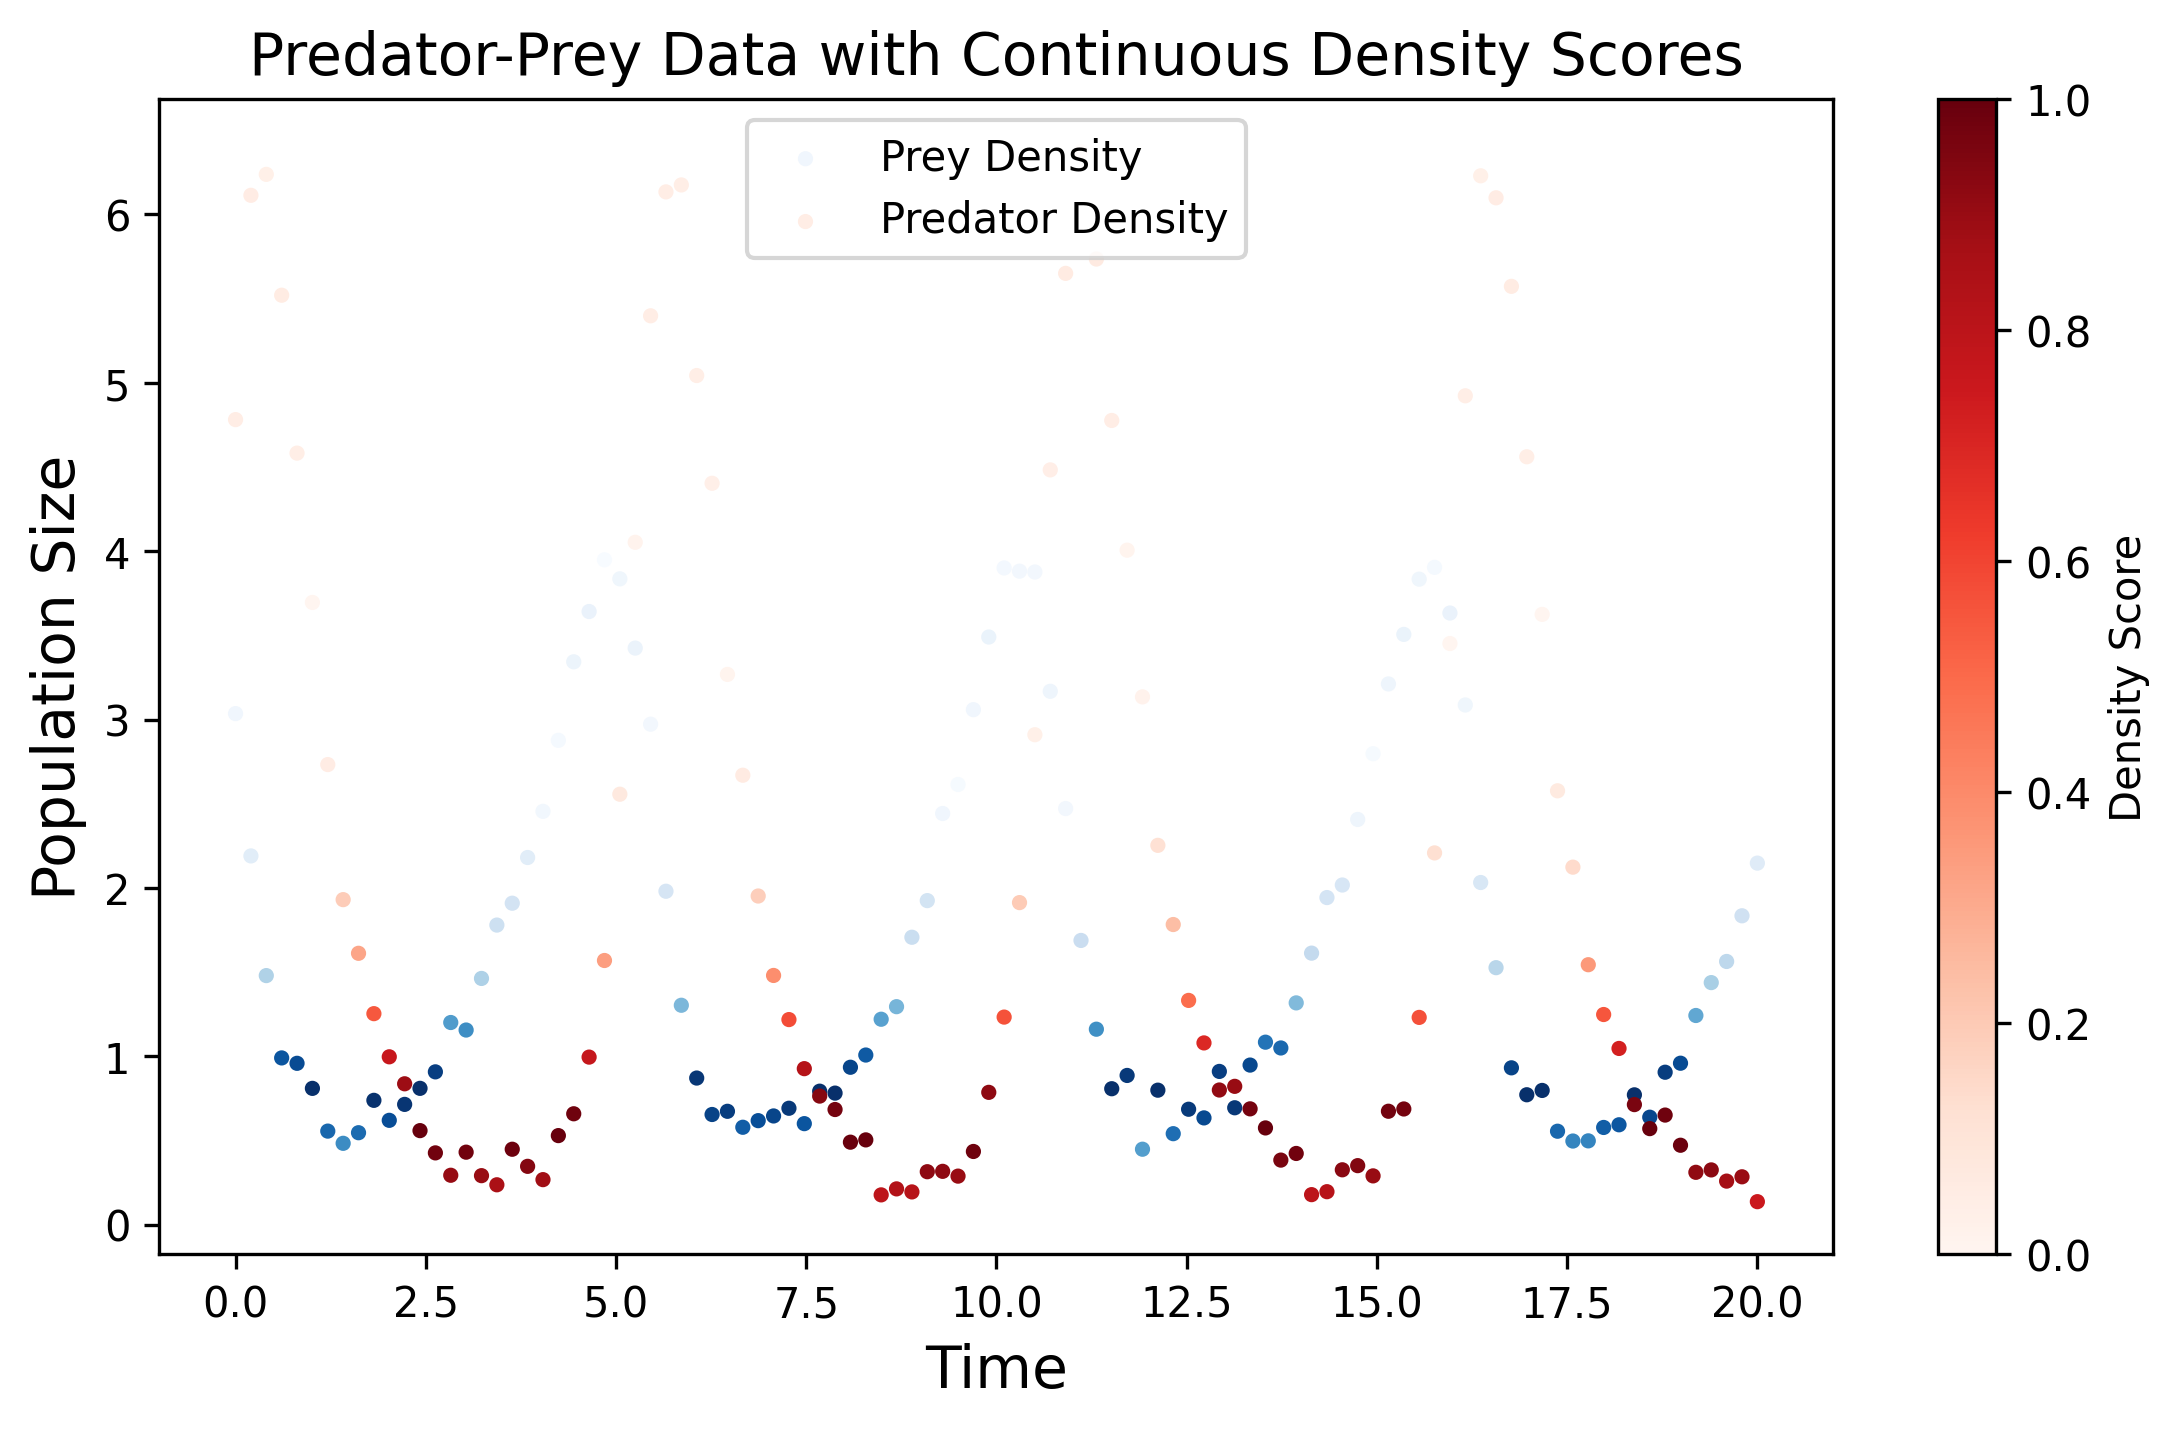

In [48]:

# Compute continuous density scores for both X_data and Y_data
density_scores_X = single_density(X_data, bandwidth=0.294297)
density_scores_Y = single_density(Y_data, bandwidth=0.495155)

# Normalize density scores to [0, 1] for coloring
norm_X = (density_scores_X - np.min(density_scores_X)) / (np.max(density_scores_X) - np.min(density_scores_X))
norm_Y = (density_scores_Y - np.min(density_scores_Y)) / (np.max(density_scores_Y) - np.min(density_scores_Y))

# Plotting with continuous density scores for coloring
plt.figure(figsize=(9, 5))
plt.title('Predator-Prey Data with Continuous Density Scores', fontsize=14)

# Prey data (X_data)
plt.scatter(t_data, X_data, c=norm_X, cmap='Blues', s=7, label='Prey Density')

# Predator data (Y_data)
plt.scatter(t_data, Y_data, c=norm_Y, cmap='Reds', s=7, label='Predator Density')

# Labels and legend
plt.xlabel('Time', fontsize=14)
plt.ylabel('Population Size', fontsize=14)
plt.colorbar(label='Density Score')
plt.legend()
plt.show()

In [97]:
def importance_sampling_deletion(X, num_deletions, Y = None, alpha = 1, bandwidth=0.5):
    """
    Perform importance sampling to delete points based on their density.
    Points with lower density are more likely to be deleted.

    Args:
        X (ndarray): Input data for the first variable (predator population).
        Y (ndarray): Input data for the second variable (prey population).
        num_deletions (int): The exact number of points to delete.
        bandwidth (float): bandwidth parameter

    Returns:
        indices (ndarray): Indices of points to delete based on importance sampling.
    """
    # Compute joint density using KDE
    if Y is None:
        density_vals = single_density(X, bandwidth)
    else: 
        density_vals = joint_density(X, Y, bandwidth)
    
    # Normalize density (weights are inverse of density)
    weights = np.exp(-density_vals / alpha)  # Inverse of density, so lower density means higher weight
    weights /= np.sum(weights)  # Normalize weights to sum to 1

    # Sample exactly num_deletions points for deletion based on the calculated weights
    deletion_indices = np.random.choice(np.arange(len(X)), size=num_deletions, 
                                replace=False, p=weights)
    
    return deletion_indices

In [99]:
def optimization_with_deletion(num_deletions, deletion_func):
    """Calculates optimal parameters for some number of deletions in the predator or prey population.

    Args:
        num_deletions (list): list of number of deletions.
        deletion_func (function): given the function, points are deleted in the predator or prey population.

    Returns:
        arrays: arrays for the mean of the parameters and the corresponding confidence intervals.
    """
    X_data_copy = X_data.copy()
    Y_data_copy = Y_data.copy()
    t_data_copy = t_data.copy()
    mean_params = np.zeros((len(num_deletions), 4))
    conf_params = np.zeros((len(num_deletions), 4))

    for i, deletions in enumerate(num_deletions):
        # Delete random data points
        np.random.seed(i)
        
        # If deleting from Y
        if deletion_func == annealing_deletion_Y:
            deletion_idx = importance_sampling_deletion(Y_data, deletions, None, alpha= 1/4, bandwidth=0.495155)  # Use Y-density for deletion
            Y_data_copy = np.delete(Y_data_copy, deletion_idx)
            t_data_copy = np.delete(t_data_copy, deletion_idx)

            deletion_Y_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed**3, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_Y_params = np.array(deletion_Y_params)
            means, confs = calc_mean_conf(deletion_Y_params)

            Y_data_copy = Y_data.copy()

        # If deleting from X
        elif deletion_func == annealing_deletion_X:
            deletion_idx = importance_sampling_deletion(X_data, deletions, None, alpha= 1/4, bandwidth=0.294297)  # Use X-density for deletion
            X_data_copy = np.delete(X_data_copy, deletion_idx)
            t_data_copy = np.delete(t_data_copy, deletion_idx)

            deletion_X_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed**3, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_X_params = np.array(deletion_X_params)
            means, confs = calc_mean_conf(deletion_X_params)

            X_data_copy = X_data.copy()

        # If deleting from both X and Y
        elif deletion_func == annealing_MAE:
            deletion_idx = importance_sampling_deletion(X_data, deletions, Y=Y_data, alpha= 1/4, bandwidth= (0.495155 + 0.294297)/2)  # Use joint-density for deletion
            X_data_copy = np.delete(X_data_copy, deletion_idx)
            Y_data_copy = np.delete(Y_data_copy, deletion_idx)
            t_data_copy = np.delete(t_data_copy, deletion_idx)

            deletion_both_params = Parallel(n_jobs=-1)(delayed(run_annealing)(deletion_func, seed*seed, X_data_copy, Y_data_copy, t_data_copy) for seed in range(25))
            deletion_both_params = np.array(deletion_both_params)
            means, confs = calc_mean_conf(deletion_both_params)

            X_data_copy = X_data.copy()
            Y_data_copy = Y_data.copy()

        mean_params[i, :] = means
        conf_params[i, :] = confs

        t_data_copy = t_data.copy()

    return mean_params, conf_params


In [51]:
num_deletions = [5, 12, 19, 26, 33, 40, 45, 50]

In [ ]:

mean_params_XY_impdel, conf_params_XY_impdel = optimization_with_deletion(num_deletions, annealing_MAE)

In [102]:
mean_params_X_impdel, conf_params_X_impdel = optimization_with_deletion(num_deletions, annealing_deletion_X)

In [103]:
mean_params_Y_impdel, conf_params_Y_impdel = optimization_with_deletion(num_deletions, annealing_deletion_Y)

In [101]:
print(mean_params_XY_impdel)

[[0.92230407 0.46624677 1.89107695 1.09237949]
 [1.0441333  0.52411114 1.74331267 1.08960027]
 [0.90341979 0.46246269 1.95359737 1.12391884]
 [0.94609529 0.48130847 1.85980238 1.07822395]
 [1.0530494  0.52178803 1.72059895 1.07996813]
 [1.1036276  0.5733138  1.5697864  1.03336876]
 [0.89634272 0.45372578 1.9370872  1.1220167 ]
 [1.02039546 0.51040321 1.68607225 1.11107961]]


In [105]:

with open('xy_imp_del_mu.pkl', 'wb') as f:
    pickle.dump(mean_params_XY_impdel, f)

with open('x_imp_del_mu.pkl', 'wb') as f:
    pickle.dump(mean_params_X_impdel, f)

with open('y_imp_del_mu.pkl', 'wb') as f:
    pickle.dump(mean_params_Y_impdel, f)

with open('xy_imp_del_conf.pkl', 'wb') as f:
    pickle.dump(conf_params_XY_impdel, f)

with open('x_imp_del_conf.pkl', 'wb') as f:
    pickle.dump(conf_params_X_impdel, f)

with open('y_imp_del_conf.pkl', 'wb') as f:
    pickle.dump(conf_params_Y_impdel, f)


In [49]:
# Load the data
with open('xy_imp_del_mu.pkl', 'rb') as f:
    mean_params_XY_impdel = pickle.load(f)

with open('x_imp_del_mu.pkl', 'rb') as f:
    mean_params_X_impdel = pickle.load(f)

with open('y_imp_del_mu.pkl', 'rb') as f:
    mean_params_Y_impdel = pickle.load(f)

with open('xy_imp_del_conf.pkl', 'rb') as f:
    conf_params_XY_impdel = pickle.load(f)

with open('x_imp_del_conf.pkl', 'rb') as f:
    conf_params_X_impdel = pickle.load(f)

with open('y_imp_del_conf.pkl', 'rb') as f:
    conf_params_Y_impdel = pickle.load(f)

# Now you can use these variables in your program


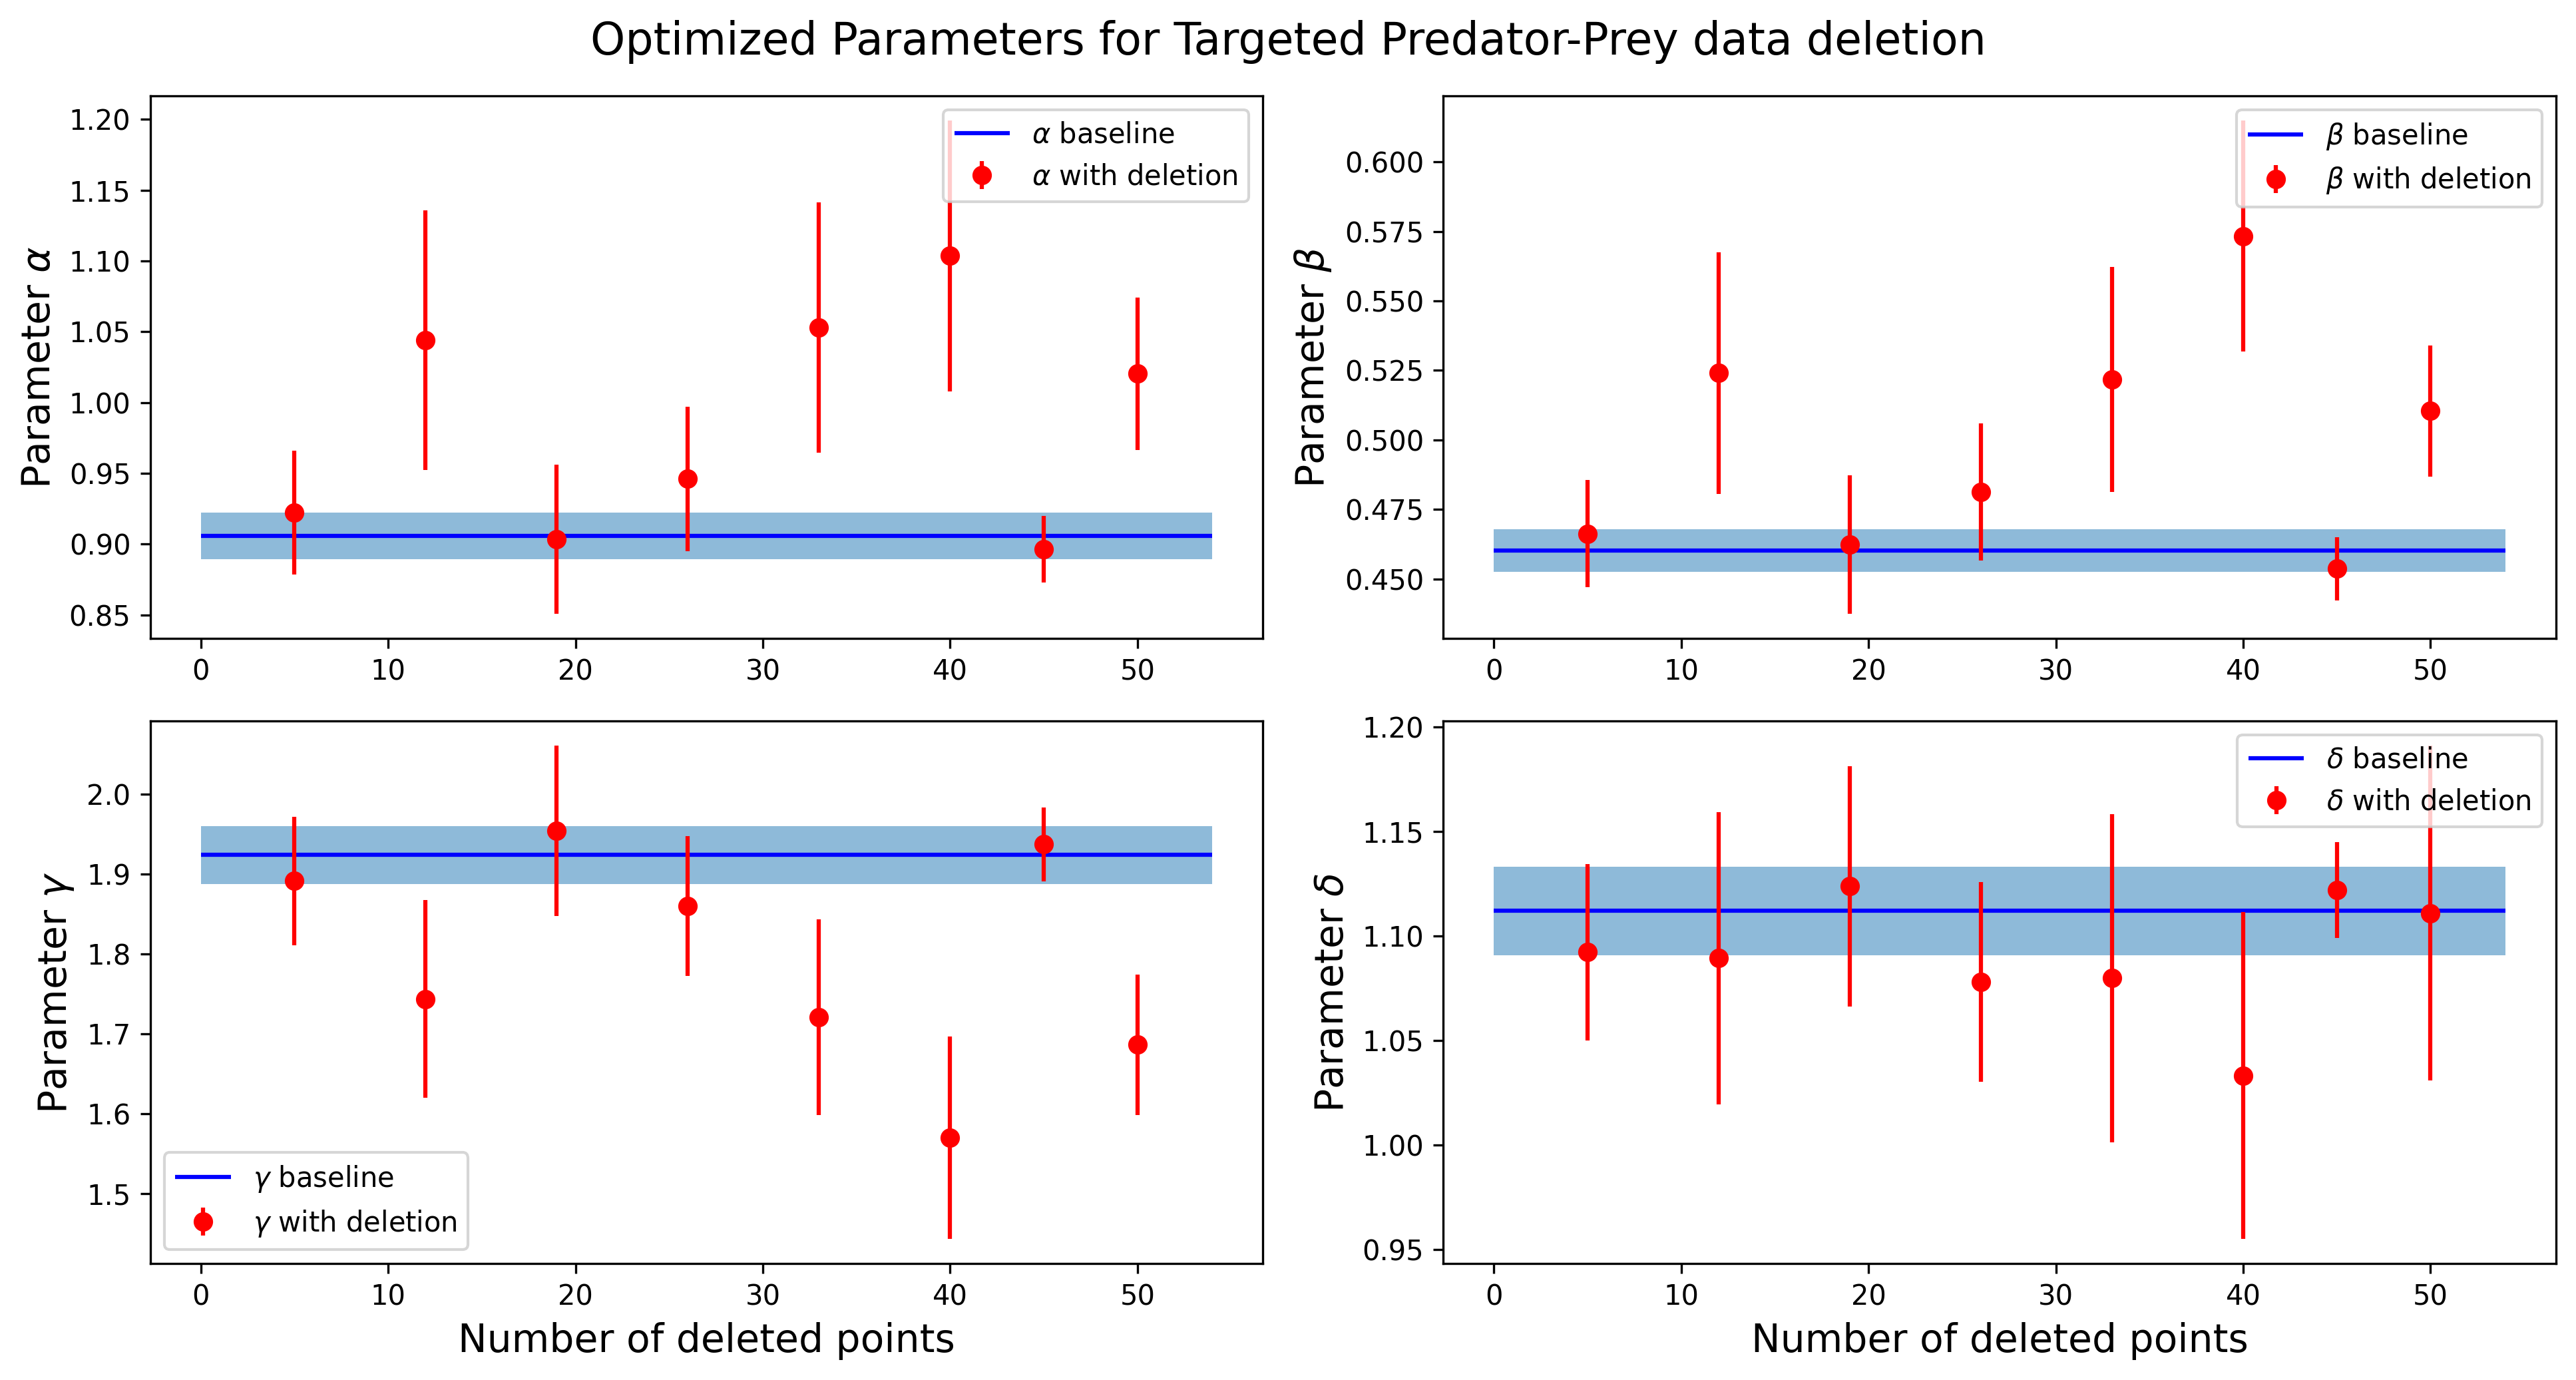

In [62]:
mean_baseline = [0.9056908959019073, 0.4602262328877057, 1.9235193601819767, 1.1121158354971876]
conf_baseline = [0.016439908242994256, 0.007730932244688599, 0.03631806994528999, 0.02110121661653635]
x_range = range(0, 55)

plt.figure(figsize=(13, 7))
plt.suptitle('Optimized Parameters for Targeted Predator-Prey data deletion', fontsize=16)

plt.subplot(2, 2, 1)
plt.hlines(mean_baseline[0], xmin=0, xmax=54, color='blue', label=r'$\alpha$ baseline')
plt.fill_between(x_range, mean_baseline[0] - conf_baseline[0], mean_baseline[0] + conf_baseline[0], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_impdel[:, 0], yerr=conf_params_XY_impdel[:, 0], fmt='o', color='red', label=r'$\alpha$ with deletion')
plt.ylabel(r'Parameter $\alpha$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 2)
plt.hlines(mean_baseline[1], xmin=0, xmax=54, color='blue', label=r'$\beta$ baseline')
plt.fill_between(x_range, mean_baseline[1] - conf_baseline[1], mean_baseline[1] + conf_baseline[1], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_impdel[:, 1], yerr=conf_params_XY_impdel[:, 1], fmt='o', color='red', label=r'$\beta$ with deletion')
plt.ylabel(r'Parameter $\beta$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 3)
plt.hlines(mean_baseline[2], xmin=0, xmax=54, color='blue', label=r'$\gamma$ baseline')
plt.fill_between(x_range, mean_baseline[2] - conf_baseline[2], mean_baseline[2] + conf_baseline[2], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_impdel[:, 2], yerr=conf_params_XY_impdel[:, 2], fmt='o', color='red', label=r'$\gamma$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\gamma$', fontsize=14)
plt.legend()

plt.subplot(2, 2, 4)
plt.hlines(mean_baseline[3], xmin=0, xmax=54, color='blue', label=r'$\delta$ baseline')
plt.fill_between(x_range, mean_baseline[3] - conf_baseline[3], mean_baseline[3] + conf_baseline[3], alpha=0.5)
plt.errorbar(num_deletions, mean_params_XY_impdel[:, 3], yerr=conf_params_XY_impdel[:, 3], fmt='o', color='red', label=r'$\delta$ with deletion')
plt.xlabel('Number of deleted points', fontsize=14)
plt.ylabel(r'Parameter $\delta$', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()